In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pygraphviz as pgv
import networkx as nx
import numpy as np
from collections import defaultdict
import seaborn as sns
import scipy
from scipy.special import gammaln, logsumexp
plt.style.use("../plotting/paper.mplstyle")
import ete3
import json
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [2]:
def build_matrix(G, ncells, nmutations):
    mat = np.zeros((ncells, nmutations))
    node_map = defaultdict()
    root = None
    for n in G.nodes():
        if G.in_degree(n) == 0:
            node_map[n] = np.array(nmutations * [0])
        elif G.out_degree(n) > 0:
            node_map[n] = np.array(nmutations * [0])
            for pred in list(nx.ancestors(G, n)):
                if int(pred) <= nmutations:
                    node_map[n][int(pred) - 1] = 1
            node_map[n][int(n) - 1] = 1
        

    for n in G.nodes():
        # Get all outgoing edges from the node
        out_edges = G.out_edges(n)
        # Extract the target nodes from the edges
        outdegree_nodes = [target for _, target in out_edges if G.out_degree(target) == 0]
        for leaf in outdegree_nodes:
            mat[int(leaf[1:])] = node_map[n]
            
    return mat

In [3]:
def build_compass_matrix(cell_assignment, genotype_file, nmutations):
    mat = np.zeros((cell_assignment.shape[0], nmutations))
    profiles = genotype_file.values[:, 1:]
    for cell in range(cell_assignment.shape[0]):
        mat[cell] = profiles[cell_assignment['node'][cell]].astype(int)
    return mat

In [4]:
def build_compass_matrix_fast(cell_assignment, genotype_file, nmutations):
    # Initialize matrix
    mat = np.zeros((cell_assignment.shape[0], nmutations), dtype=int)
    
    # Extract only relevant rows from profiles based on cell_assignment
    profiles = genotype_file.values[:, 1:][cell_assignment['node'].values]
    
    # Directly assign to the matrix
    mat[:] = profiles
    
    return mat

In [5]:
def clonal_accuracy(original_map, inferred, num_cells, opt=30):
    inferred_map = defaultdict(set)
    
    timepoint_count = defaultdict()
    for r in range(inferred.shape[0]):  
        inferred_map[" ".join(map(str, map(int, inferred[r])))].add(r//num_cells)
    
        if " ".join(map(str, map(int, inferred[r]))) not in timepoint_count.keys():
            timepoint_count[" ".join(map(str, map(int, inferred[r])))] = defaultdict(int)
        timepoint_count[" ".join(map(str, map(int, inferred[r])))][r//num_cells] += 1
        if timepoint_count[" ".join(map(str, map(int, inferred[r])))][r//num_cells] >= opt:
            inferred_map[" ".join(map(str, map(int, inferred[r])))].add(r//num_cells)
    
    diffs = 0
    for k in original_map.keys():
        diffs += len(original_map[k].symmetric_difference(inferred_map[k]))
    return diffs

In [6]:
def clonal_accuracy_fast(original_map, inferred, num_cells, opt=30):
    inferred_map = defaultdict(set)
    timepoint_count = defaultdict(int)
    
    for r in range(inferred.shape[0]):
        # Convert row to tuple instead of string for faster operations
        row_key = tuple(inferred[r])
        cell_timepoint = r // num_cells
        
        # Track inferred_map and timepoint_count with optimized keying
        inferred_map[row_key].add(cell_timepoint)
        timepoint_key = (row_key, cell_timepoint)
        
        # Directly check and update based on timepoint count
        timepoint_count[timepoint_key] += 1
        if timepoint_count[timepoint_key] >= opt:
            inferred_map[row_key].add(cell_timepoint)
    
    # Calculate differences
    diffs = sum(len(original_map.get(k, set()).symmetric_difference(inferred_map.get(k, set())))
                for k in original_map)
    
    return diffs

In [7]:
def calculate_likelihood(original, inferred, prop):
    l = 0
    fp = prop/2
    fn = prop/2
    fn_weight = np.log(fn) - np.log(1-fn)
    fp_weight = np.log(1-fp) - np.log(fp)
    one_cnt = 0
    for r in range(original.shape[0]):
        zero_elem = np.where(original[r] == 0, 1, 0)
        one_elem = np.where(original[r] == 1, 1, 0)
        l += (fn_weight * np.dot(zero_elem, inferred[r]) + fp_weight * np.dot(one_elem, inferred[r]))
        one_cnt += sum(inferred[r])
    return l

In [8]:
def calculate_likelihood_rc(inferred, variant, total, prop):
    l = 0
    fp_error_rate = prop/2
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for r in range(inferred.shape[0]):
        prof = np.zeros(inferred.shape[1])
        for c in range(inferred.shape[1]):
            if total[r,c] > 0.5 and inferred[r,c] > 0.5:
                l += scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], 1, 1) 
            elif total[r,c] > 0.5 and inferred[r,c] < 0.5:
                l += scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], alpha, beta)


    return l

In [9]:
def compute_SNV_loglikelihoods(c_ref, c_alt, r, v, locus, dropout_rate_ref, dropout_rate_alt, sequencing_error_rate, n_cells):
    # If homozygous, the copy number of the only allele is irrelevant for the allelic proportion
    if (c_ref==0):
        c_alt=1
    elif (c_alt==0):
        c_ref==1


    likelihood_alleles_cells = [[] for _ in range((c_ref + 1) * (c_alt + 1) - 1)]
    dropoutscores = [0.0] * n_cells

    idx = 0
    for k in range(c_ref):
        for l in range(c_alt + 1):
            if k == 0 and l == 0:
                continue
                        
            seq_error_rates = [0.0] * n_cells
            eps1 = sequencing_error_rate
            eps2 = sequencing_error_rate
            omega = 50 if k == 0 or l == 0 else 8
            

            f = (1.0 * l / (k + l)) * (1 - eps2) + (1.0 * k / (k + l)) * eps1

            for j in range(n_cells):
                ref_count = r
                alt_count = v
                likelihood_dropout = (gammaln(alt_count + omega * f) + 
                                      gammaln(ref_count + omega * (1 - f)) - 
                                      gammaln(alt_count + ref_count + omega) - 
                                      gammaln(omega * f) - 
                                      gammaln(omega * (1 - f)) + 
                                      gammaln(omega))
                dropoutscores[j] = likelihood_dropout


            likelihood_alleles_cells[idx] = [0.0] * n_cells
            dropout_prob = (log_n_choose_k(c_ref, k) + log_n_choose_k(c_alt, l) + 
                            (c_ref - k) * np.log(dropout_rate_ref) + 
                            k * np.log(1 - dropout_rate_ref) + 
                            (c_alt - l) * np.log(dropout_rate_alt) + 
                            l * np.log(1 - dropout_rate_alt))
            all_dropout_prob = (dropout_rate_ref ** c_ref) * (dropout_rate_alt ** c_alt)
            dropout_prob -= np.log(1 - all_dropout_prob)

            for j in range(n_cells):
                likelihood_alleles_cells[idx][j] = dropoutscores[j] + dropout_prob

            idx += 1
            
    if c_alt == 0:
        scores_cells = logsumexp(likelihood_alleles_cells[:-1], axis=0)
    else:
        scores_cells = logsumexp(likelihood_alleles_cells[:-2], axis=0)

    dropoutsref = [0.0] * n_cells
    dropoutsalt = [0.0] * n_cells

    idx = 0
    for k in range(c_ref):
        for l in range(c_alt + 1):
            if k == 0 and l == 0:
                continue

            for j in range(n_cells):
                config_prob = np.exp(likelihood_alleles_cells[idx][j] - scores_cells[j])
                dropoutsref[j] += (c_ref - k) * config_prob
                dropoutsalt[j] += (c_alt - l) * config_prob

            idx += 1

    return scores_cells, dropoutsref, dropoutsalt

In [10]:
def log_n_choose_k(n, k):
    return gammaln(n + 1) - (gammaln(k + 1) + gammaln(n - k + 1))

In [11]:
def calculate_likelihood_COMPASS(inferred, variant, total, prop):
    l = 0
    fp_error_rate = prop/2
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for r in range(inferred.shape[0]):
        for c in range(inferred.shape[1]):
            if inferred[r,c] > 0.5:
                l += compute_SNV_loglikelihoods(1, 1, total[r,c] - variant[r,c],  variant[r,c], c, 0.01, 0.01, prop, 1)[0][0]
            else:
                l += compute_SNV_loglikelihoods(2, 0, total[r,c] - variant[r,c],  variant[r,c], c, 0.01, 0.01, prop, 1)[0][0]
    return l



In [12]:
def row_to_binary_string(row):
    return ''.join(format(x, '08b') for x in row)

def sort_rows_by_binary_encoding(array):
    # Convert rows to binary strings
    binary_strings = np.array([row_to_binary_string(row) for row in array])
    
    # Get the sorted indices based on binary string values
    sorted_indices = np.argsort(binary_strings)
    
    # Sort the array using the sorted indices
    sorted_array = array[sorted_indices]
    
    return sorted_array

def pad_array_with_zeros(smaller_array, target_shape):
    padding_rows = target_shape[0] - smaller_array.shape[0]
    if padding_rows > 0:
        # Create an array of zeros with the same number of columns as the smaller array
        padding = np.zeros((padding_rows, smaller_array.shape[1]))
        # Append the zero rows to the smaller array
        padded_array = np.vstack((padding, smaller_array))
    else:
        padded_array = smaller_array
    return padded_array

def return_score(original, inferred):
    score = 0
    for r in range(inferred.shape[0]):
        for r2 in range(original.shape[0]):
            if np.array_equal(original[r2], inferred[r]) == True:
                score += 1
    return score

In [13]:
def remove_duplicate_legend_entries(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys(), loc='upper left', fontsize=16)

In [19]:
def is_longitudinally_consistent(matrix, size, threshold=1, verbose=True):
    is_complete_sequence = lambda values: set(range(min(values), max(values) + 1)) == set(values) if values else False

        
    time_cells = defaultdict()
    
    tvec = []
    for i in range(len(size)):
        tvec.extend([i]*size[i])
    
    for r in range(matrix.shape[0]):
        if " ".join(map(str, map(int, matrix[r]))) not in time_cells:
            time_cells[" ".join(map(str, map(int, matrix[r])))] = defaultdict(int)
        time_cells[" ".join(map(str, map(int, matrix[r])))][tvec[r]] += 1
    
    for k in time_cells.keys():
        time_cells[k] = {k: v for k, v in time_cells[k].items() if v >= threshold}
    

    
    for k in time_cells.keys():
        if is_complete_sequence(list(time_cells[k].keys())) == False:
            if verbose:
                print(list(time_cells[k].keys()))
            return False
        
    for k1 in time_cells.keys():
        par_k1 = None
        min_distance = -1
        k1_list = list(map(int, k1.split()))
        for k2 in time_cells.keys():
            if k1 != k2:
                k2_list = list(map(int, k2.split()))
                if all(k1_list[i] == 0 for i in range(len(k2_list)) if k2_list[i] == 0):
                    dist = sum(np.array(k1_list))
                    if dist > min_distance:
                        min_distance = dist
                        par_k1 = k2
        if par_k1 is not None:
            if min(list(time_cells[k1].keys())) > min(list(time_cells[par_k1].keys())):
                if verbose:
                    print('Fail1', k1, "|", par_k1)
                return False
            if max(list(time_cells[k1].keys())) + 1 < min(list(time_cells[par_k1].keys())):
                if verbose:
                    print('Fail2', k1, "|", par_k1)
                    print(time_cells[k1], time_cells[par_k1])
                return False


                
    return True

In [20]:
def is_longitudinally_consistent_val(matrix, size, threshold=1, verbose=True):
    is_complete_sequence = lambda values: set(range(min(values), max(values) + 1)) == set(values) if values else False
    
    violations = 0
        
    time_cells = defaultdict()
    
    tvec = []
    for i in range(len(size)):
        tvec.extend([i]*size[i])
    
    for r in range(matrix.shape[0]):
        if " ".join(map(str, map(int, matrix[r]))) not in time_cells:
            time_cells[" ".join(map(str, map(int, matrix[r])))] = defaultdict(int)
        time_cells[" ".join(map(str, map(int, matrix[r])))][tvec[r]] += 1
    
    for k in time_cells.keys():
        time_cells[k] = {k: v for k, v in time_cells[k].items() if v >= threshold}
    

    
    for k in time_cells.keys():
        if is_complete_sequence(list(time_cells[k].keys())) == False:
            if verbose:
                print("PE FAIL", list(time_cells[k].keys()))
            violations += 1
        
    for k1 in time_cells.keys():
        par_k1 = None
        min_distance = -1
        k1_list = list(map(int, k1.split()))
        for k2 in time_cells.keys():
            if k1 != k2:
                k2_list = list(map(int, k2.split()))
                if all(k1_list[i] == 0 for i in range(len(k2_list)) if k2_list[i] == 0):
                    dist = sum(np.array(k1_list))
                    if dist > min_distance:
                        min_distance = dist
                        par_k1 = k2
        if par_k1 is not None:
            if min(list(time_cells[k1].keys())) > min(list(time_cells[par_k1].keys())):
                if verbose:
                    print('Fail1', k1, "|", par_k1)
                violations += 1
            if max(list(time_cells[k1].keys())) + 1 < min(list(time_cells[par_k1].keys())):
                if verbose:
                    print('Fail2', k1, "|", par_k1)
                    print(time_cells[k1], time_cells[par_k1])
                violations += 1


                
    return violations

In [29]:
def ppm_to_tree(matrix, labels=None):
    """
    Convert a Perfect Phylogeny Matrix (PPM) to an ete3 tree.
    
    Args:
        matrix (np.ndarray): Binary PPM with rows as species and columns as characters.
        labels (list): List of labels for the rows. If None, default names will be used.
    
    Returns:
        Tree: An ete3 tree object.
    """
    matrix = np.unique(matrix, axis=0)
    if labels is None:
        labels = [f"Species_{i+1}" for i in range(matrix.shape[0])]
    
    # Start with a root node
    root = ete3.Tree()
    
    # Create nodes for each unique row
    unique_rows, row_indices = np.unique(matrix, axis=0, return_inverse=True)
    node_map = {}
    
    for i, unique_row in enumerate(unique_rows):
        # Create a node for each unique pattern
        node_label = f"State_{i+1}"
        node_map[tuple(unique_row)] = root.add_child(name=node_label)
    
    # Attach each species to the appropriate state
    for row, label in zip(matrix, labels):
        state_node = node_map[tuple(row)]
        state_node.add_child(name=label)
    
    return root

# Example PPM
matrix = np.array([
    [1, 0, 0],
    [1, 1, 0],
    [1, 1, 1],
    [1, 0, 0]
])
labels = ["A", "B", "C", "D"]

# Convert PPM to tree
tree = ppm_to_tree(matrix, labels)

# Display the tree
print(tree)

#tree.show()


   /- /-A
  |
--|-- /-B
  |
   \- /-C


# Imputation Methods Comparison

### Parameters

In [24]:
# Variable Parameters 
ncells_per_sample = 100
timepoints = [3]
error_rates = [0.05] #[0.01, 0.05, 0.075, 0.10, 0.125, 0.15]
num_replicates = 10

# Fixed Parameters
nmutations = 10

## Plot Normalized Matrix Error

### Box Plot

KeyboardInterrupt: 

<Figure size 1800x1200 with 0 Axes>

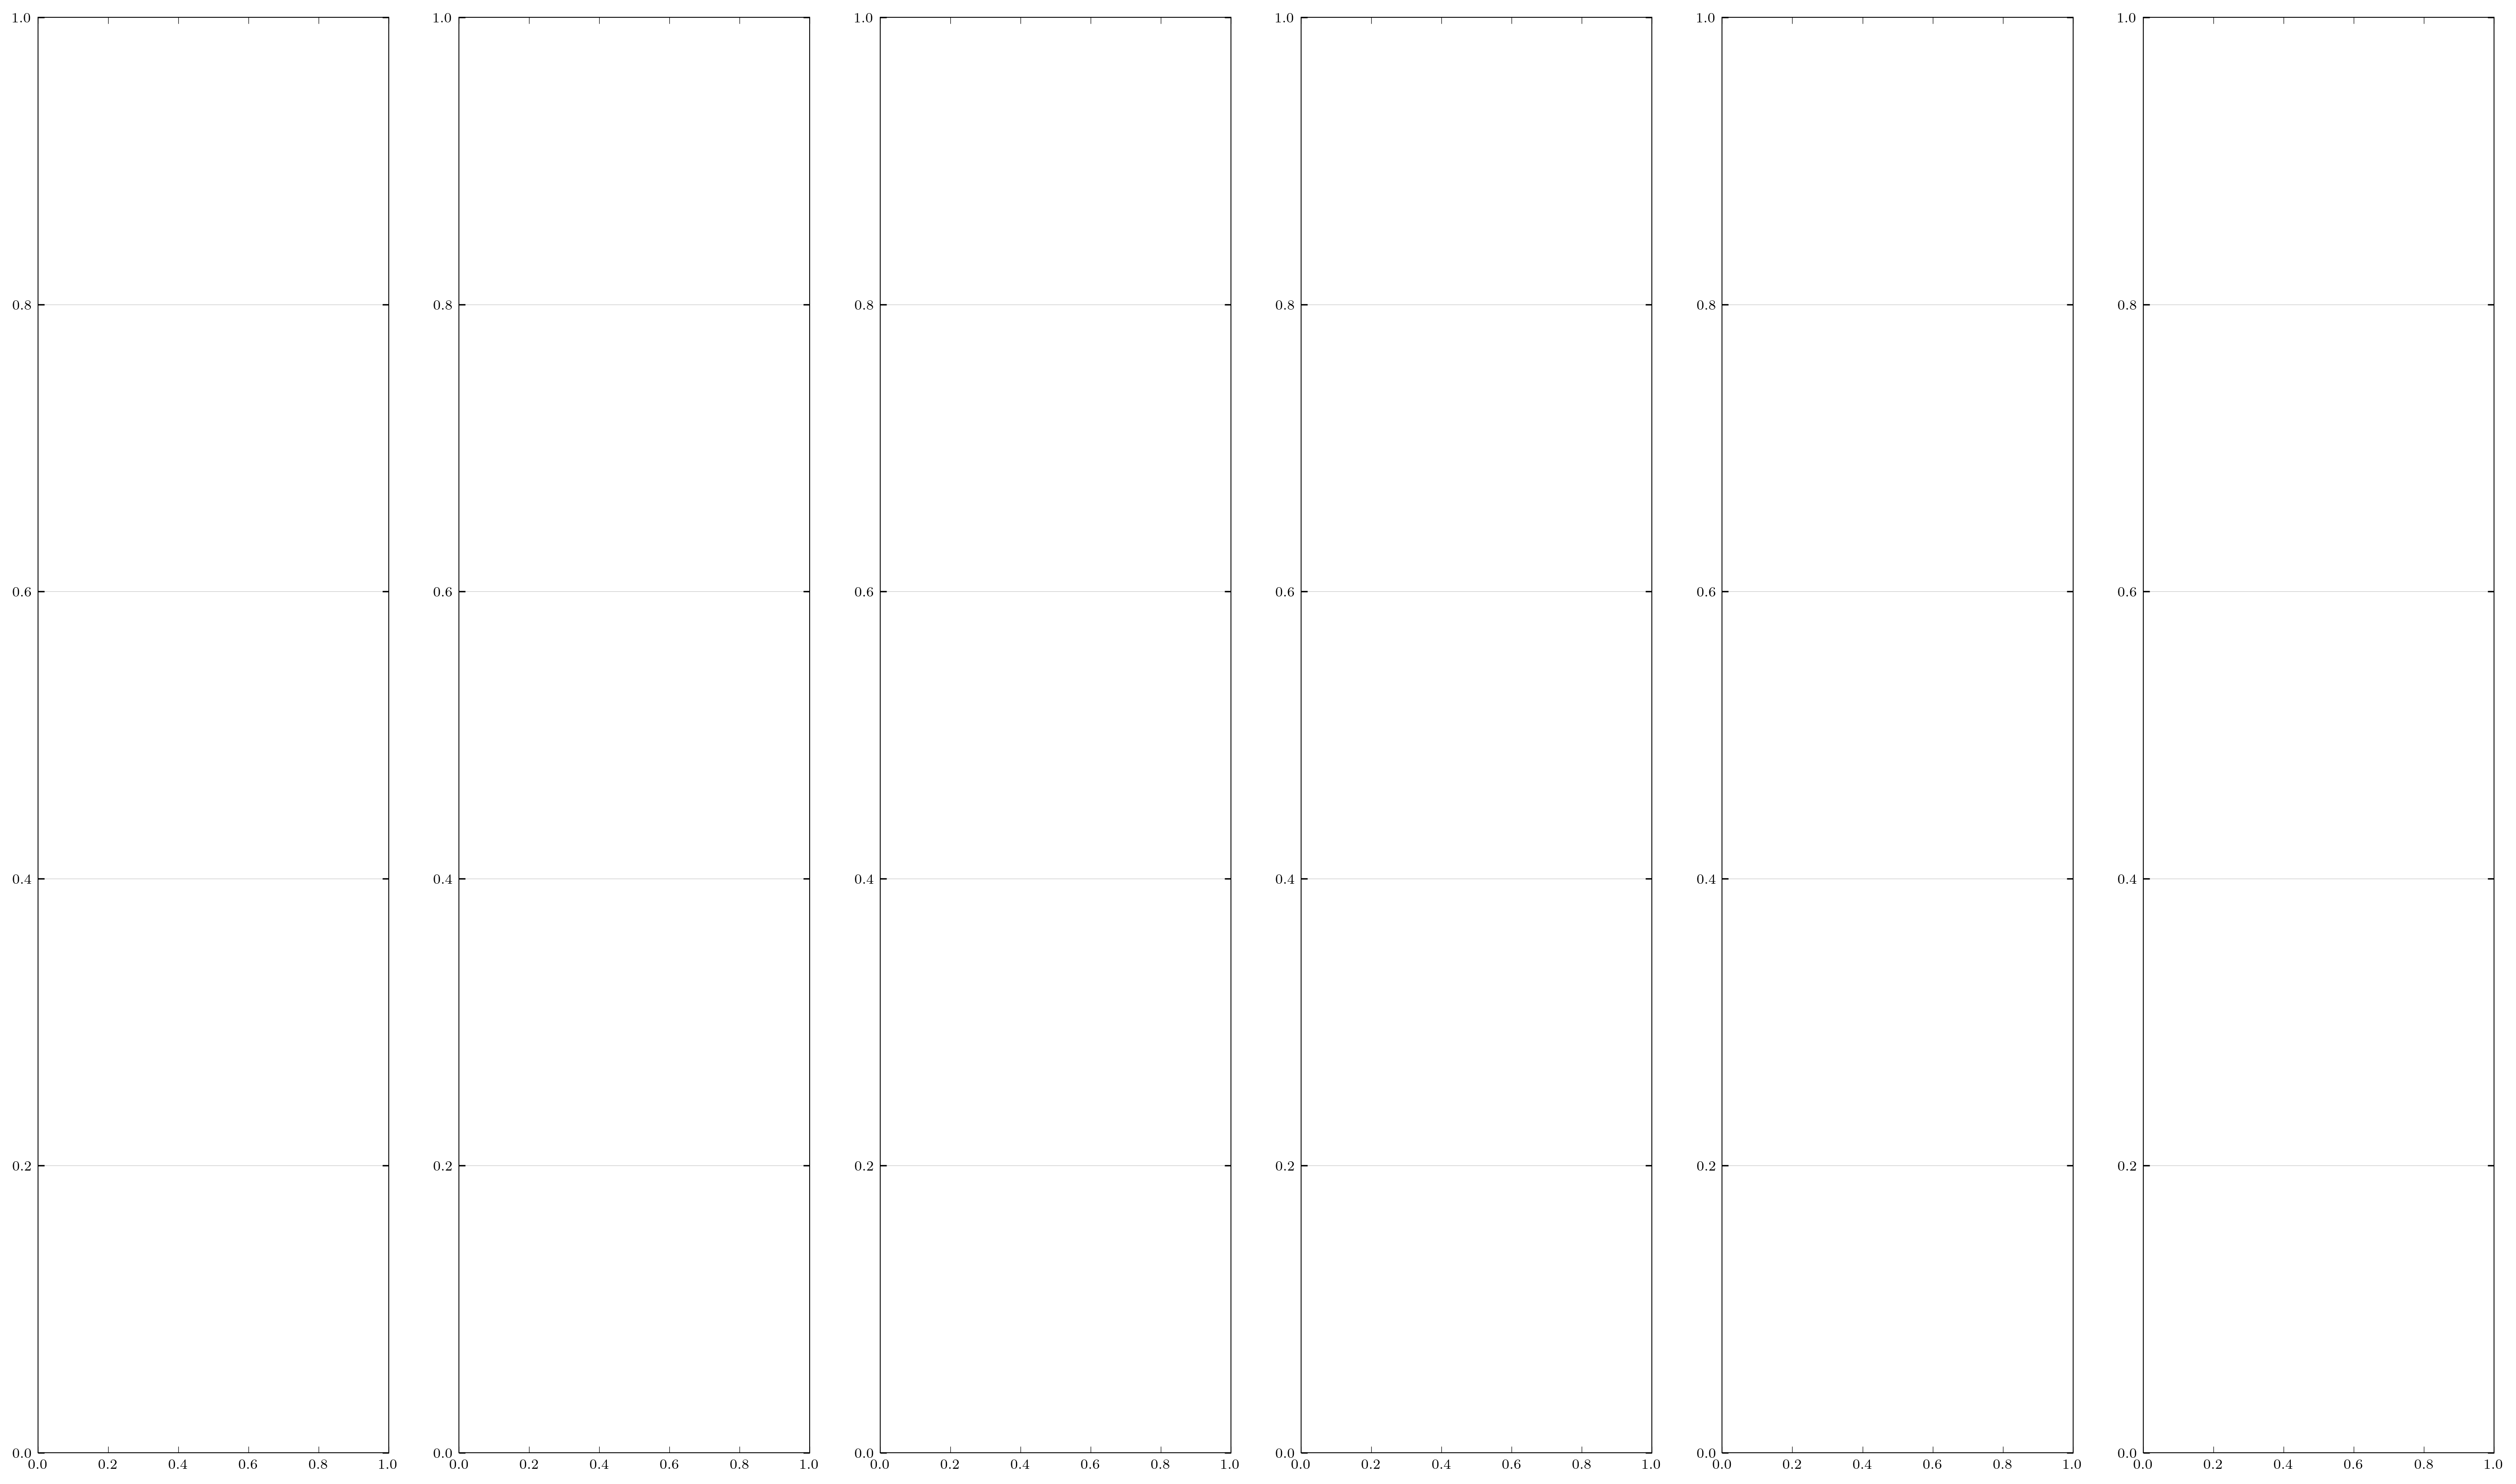

In [39]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(25, 15))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                
                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                            
                
                phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(ncells_per_sample * nmutations * t))
                phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(ncells_per_sample * nmutations * t))
                SPhyR_diffs.append(np.sum(np.abs(og_character_matrix - SPhyR_character_matrix))/(ncells_per_sample * nmutations * t))
                SCITE_diffs.append(np.sum(np.abs(og_character_matrix - SCITE_character_matrix))/(ncells_per_sample * nmutations * t))


        data = pd.DataFrame({'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'], 'Normalized Matrix Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})
        axs[i,j].set_ylim(0, 0.15)
        sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()


plt.show()

### Line Plot

0 0
0 1
0 2
0 3
0 4
0 5


<Figure size 1800x1200 with 0 Axes>

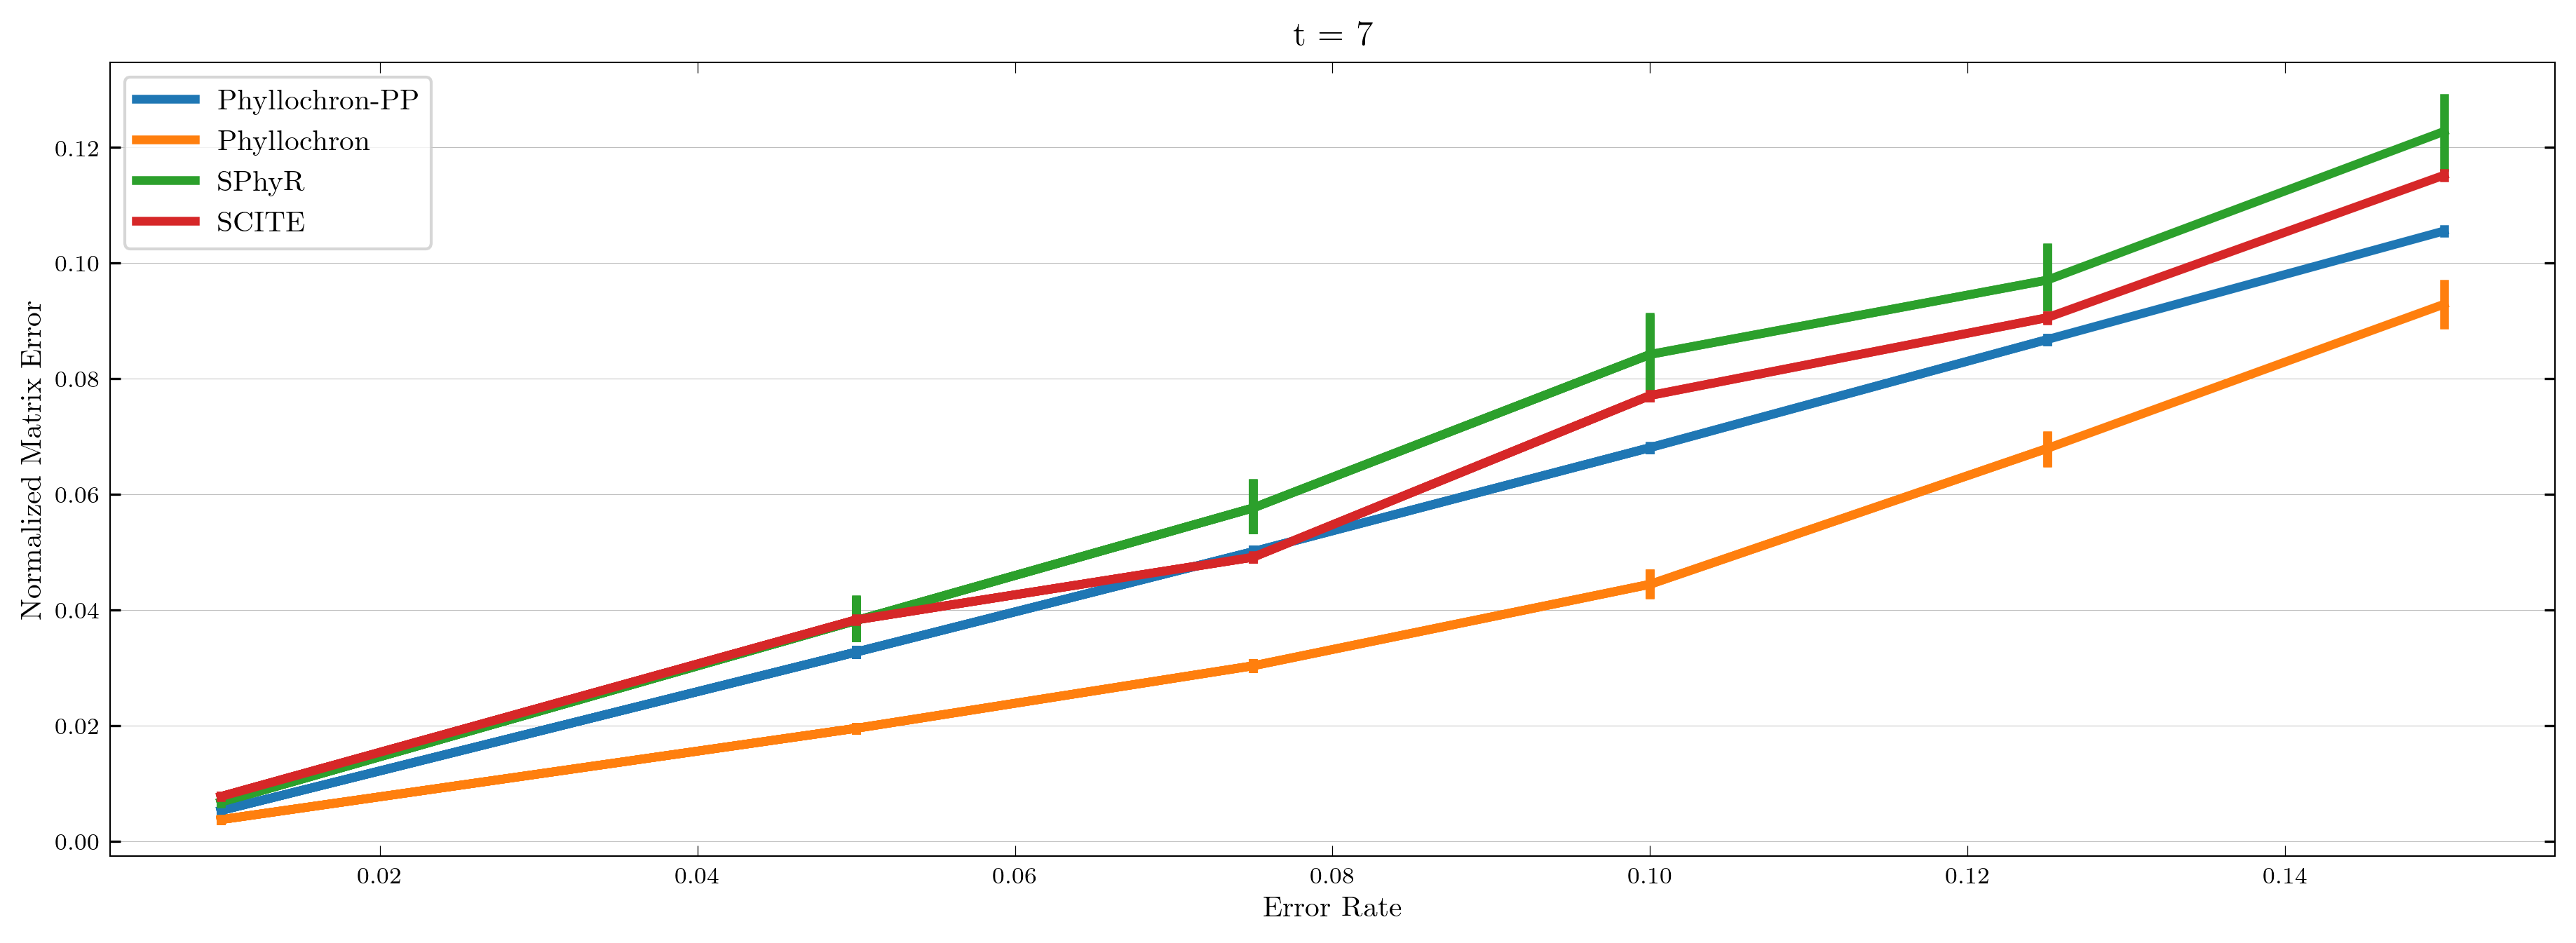

In [42]:
plt.figure()
fig, axs = plt.subplots(1, len(timepoints), figsize=(15, 5))
for i, t in enumerate(timepoints):
    all_data = []
    for j, prop in enumerate(error_rates):
        print(i,j)
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)


                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(ncells_per_sample * nmutations * t))
                phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(ncells_per_sample * nmutations * t))
                SPhyR_diffs.append(np.sum(np.abs(og_character_matrix - SPhyR_character_matrix))/(ncells_per_sample * nmutations * t))
                SCITE_diffs.append(np.sum(np.abs(og_character_matrix - SCITE_character_matrix))/(ncells_per_sample * nmutations * t))

        
        data = pd.DataFrame({'Error Rate': (4*num_replicates)*[prop],'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'], 'Normalized Matrix Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})
        
        #axs[i,j].set_ylim(0, 0.20)
        #sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs.set_title(f't = {t}')
        all_data.append(data)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.lineplot(data=data_final, x='Error Rate', y="Normalized Matrix Error", hue="Type", err_style="bars", ax=axs)

# Apply function to each subplot
remove_duplicate_legend_entries(axs)

plt.show()

In [51]:
np.mean(data_final[(data_final["Type"]=="Phyllochron-PP") & (data_final["Error Rate"]==0.15)])

Error Rate                 0.150000
Normalized Matrix Error    0.105558
dtype: float64

## Plot Likelihood


0 0
1 0
2 0
0 1
1 1
2 1
0 2
1 2
2 2
0 3
1 3
2 3
0 4
1 4
2 4


<Figure size 1800x1200 with 0 Axes>

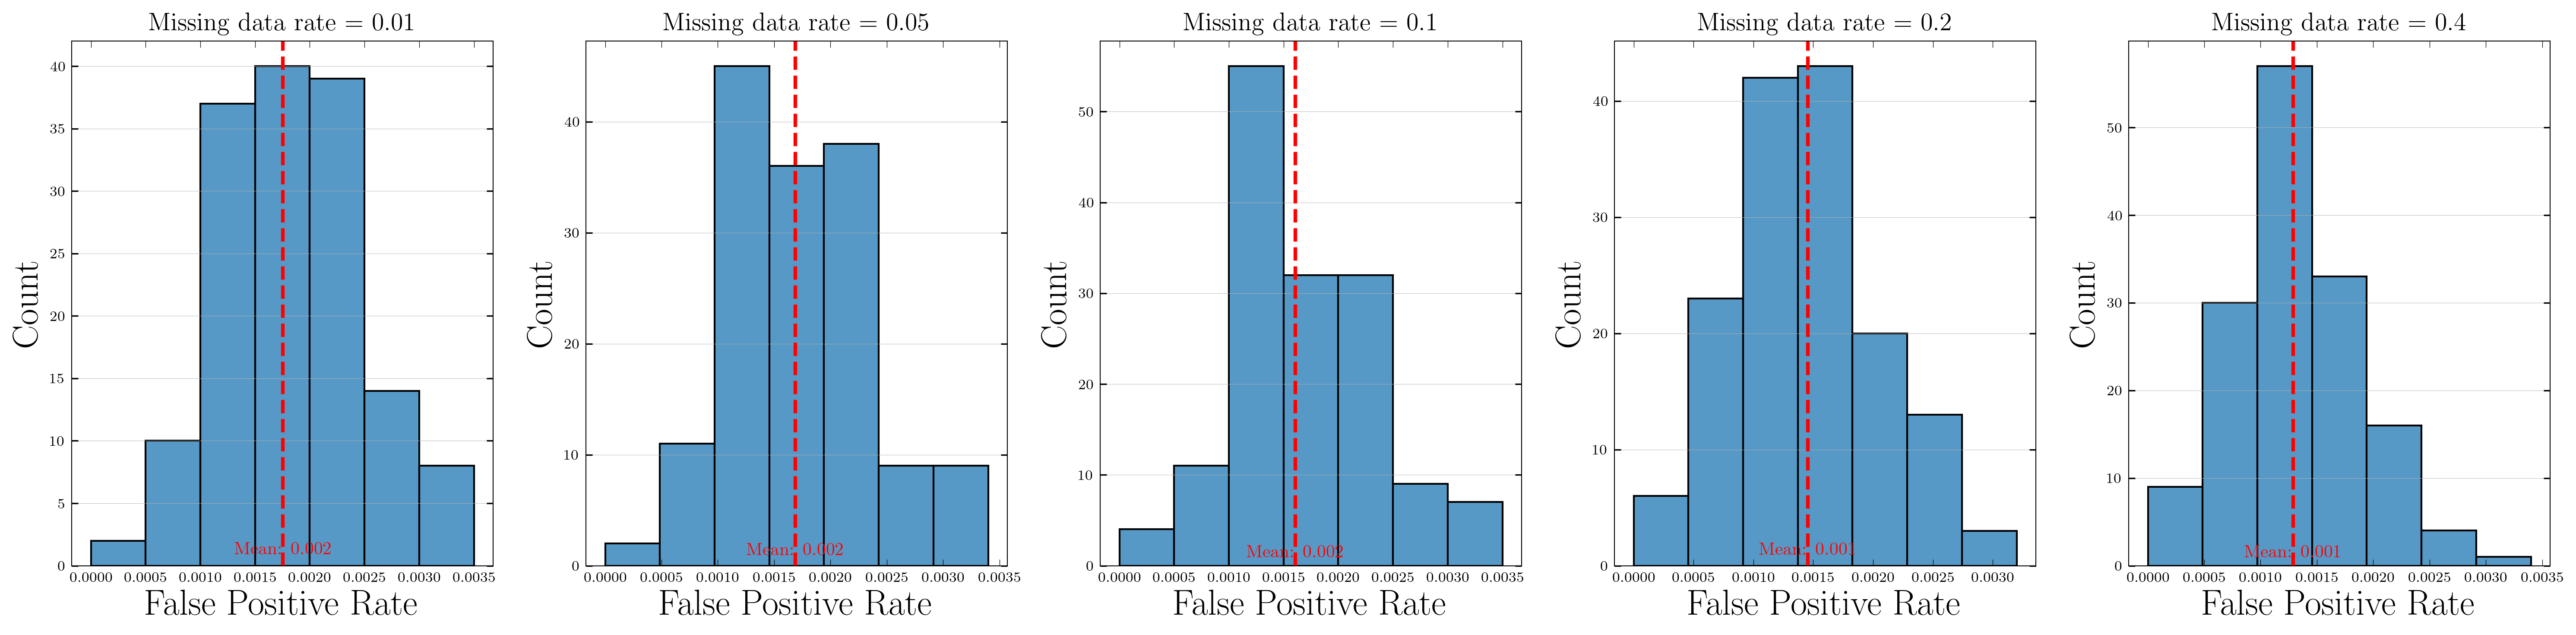

In [207]:
plt.figure()
fig, axs = plt.subplots(1, len(error_rates), figsize=(20, 5))
for j, prop in enumerate(error_rates):
    fps = []
    fns = []
    for i, t in enumerate(timepoints):
        print(i,j)

        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{n}_{t}_{prop}_{sd}.csv').values[:, 1:]
                input_df = pd.read_csv(f'../simulations/ground_truth_rc/sphyr_{n}_{t}_{prop}_{sd}.txt', sep='\t',skiprows=2, header=None)
                
                input_character_matrix = input_df.values.astype(int) 
                diff = og_character_matrix - input_character_matrix
                
                fn = np.count_nonzero(diff == 1)/(og_character_matrix.shape[0] * og_character_matrix.shape[1])
                fp = np.count_nonzero(diff == -1)/(og_character_matrix.shape[0] * og_character_matrix.shape[1])
                fps.append(fp)
                fns.append(fn)
    data = pd.DataFrame({'False Positive Rate': fps, "False Negative Rate": fns})
    #axs[j].tick_params(axis='x', labelrotation=45)
    #axs[i,j].set_ylim(12000, 120000)
    mean_value = np.mean(data['False Positive Rate'])

    # Add a red dotted line at the mean
    axs[j].axvline(mean_value, color='red', linestyle='--', linewidth=2)
    axs[j].text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.3f}', 
         color='red', ha='center')
    sns.histplot(x='False Positive Rate', data=data, bins=7, ax = axs[j])
    #axs[i,j].set_title(f't = {t}, error rate = {prop}')
    axs[j].set_title(f"Missing data rate = {prop}", fontsize=14)
    #axs[j].legend(loc='upper left')
    axs[j].set_ylabel(f"Count", fontsize=20)
    axs[j].set_xlabel(f"False Positive Rate", fontsize=20)
fig.tight_layout()       
plt.show()

0 0
1 0
2 0
0 1
1 1
2 1
0 2
1 2
2 2
0 3
1 3
2 3
0 4
1 4
2 4


<Figure size 1800x1200 with 0 Axes>

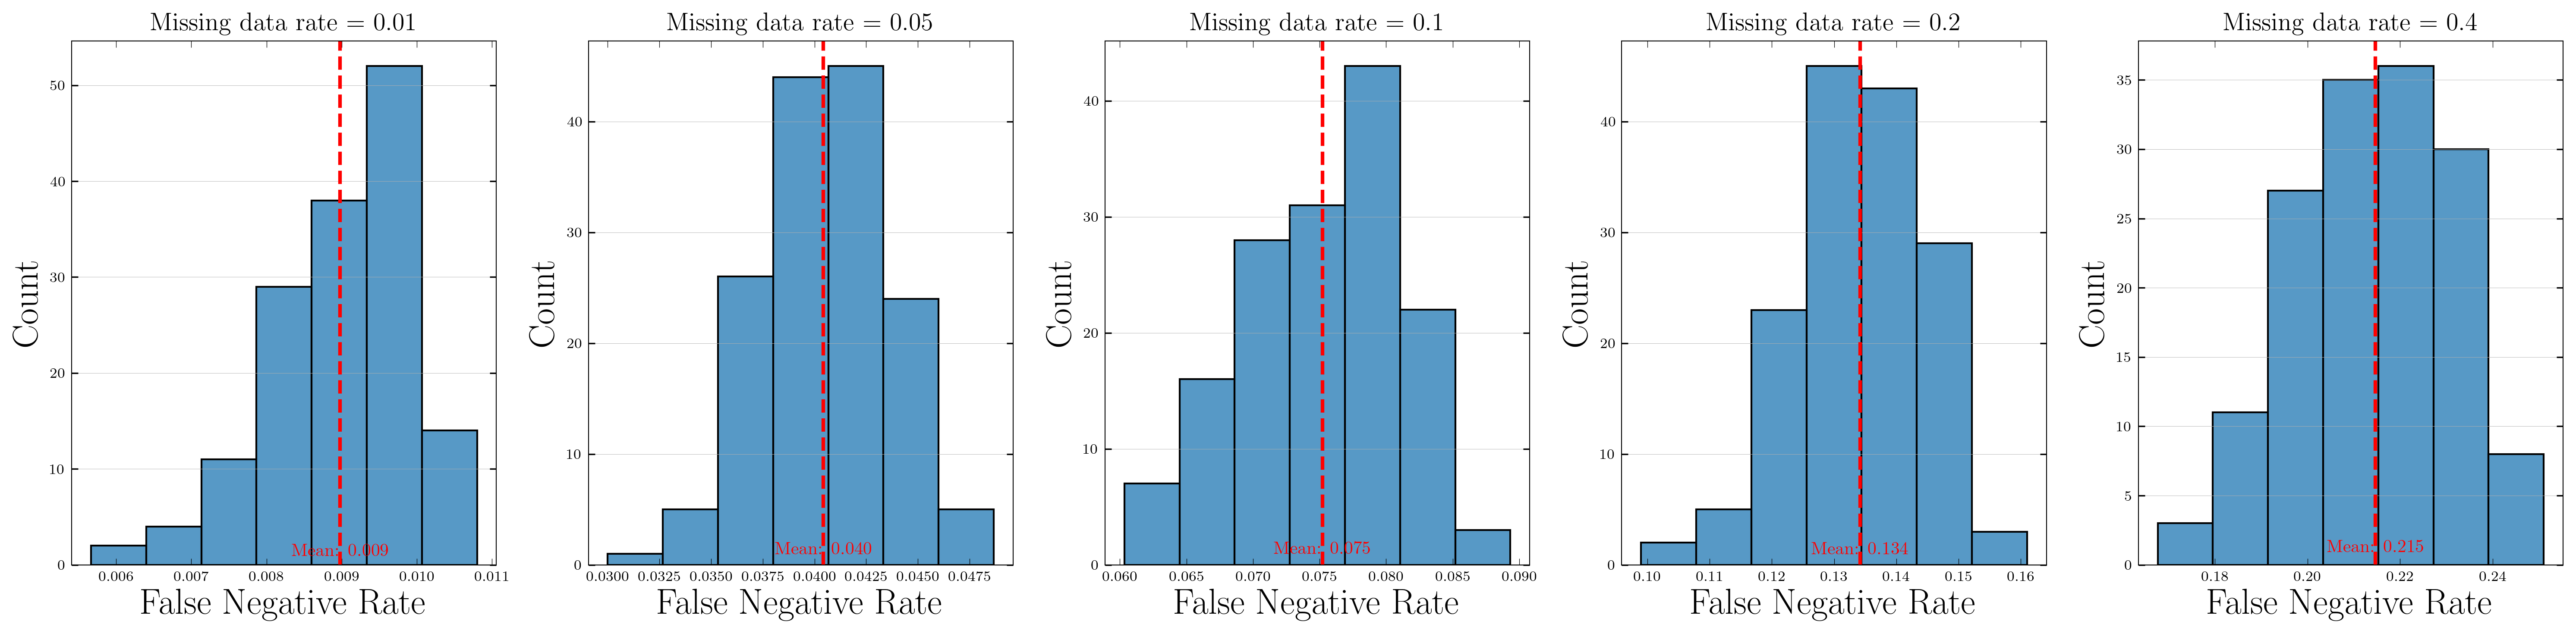

In [208]:
plt.figure()
fig, axs = plt.subplots(1, len(error_rates), figsize=(20, 5))
for j, prop in enumerate(error_rates):
    fps = []
    fns = []
    for i, t in enumerate(timepoints):
        print(i,j)

        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{n}_{t}_{prop}_{sd}.csv').values[:, 1:]
                input_df = pd.read_csv(f'../simulations/ground_truth_rc/sphyr_{n}_{t}_{prop}_{sd}.txt', sep='\t',skiprows=2, header=None)
                
                input_character_matrix = input_df.values.astype(int) 
                diff = og_character_matrix - input_character_matrix
                
                fn = np.count_nonzero(diff == 1)/(og_character_matrix.shape[0] * og_character_matrix.shape[1])
                fp = np.count_nonzero(diff == -1)/(og_character_matrix.shape[0] * og_character_matrix.shape[1])
                fps.append(fp)
                fns.append(fn)
    data = pd.DataFrame({'False Positive Rate': fps, "False Negative Rate": fns})
    #axs[j].tick_params(axis='x', labelrotation=45)
    #axs[i,j].set_ylim(12000, 120000)
    mean_value = np.mean(data['False Negative Rate'])

    # Add a red dotted line at the mean
    axs[j].axvline(mean_value, color='red', linestyle='--', linewidth=2)
    axs[j].text(mean_value, plt.ylim()[1] * 0.9, f'Mean: {mean_value:.3f}', 
         color='red', ha='center')
    sns.histplot(x='False Negative Rate', data=data, bins=7, ax = axs[j])
    #axs[i,j].set_title(f't = {t}, error rate = {prop}')
    axs[j].set_title(f"Missing data rate = {prop}", fontsize=14)
    #axs[j].legend(loc='upper left')
    axs[j].set_ylabel(f"Count", fontsize=20)
    axs[j].set_xlabel(f"False Negative Rate", fontsize=20)
fig.tight_layout()       
plt.show()

## Plot Clonal Lifespan Accuracy

### Box Plot

# Readcount Methods Comparison

### Parameters

In [441]:
# Variable Parameters 
timepoints = [3,4,5]
error_rates = [0.01, 0.05, 0.10, 0.20, 0.40]
num_replicates = 3

# Fixed Parameters
nmutations = 5
n = 100
ncells_per_sample = 100

## Plot Normalized Matrix Error

In [14]:
# Variable Parameters 
timepoints = [3,4,5]
error_rates = [0.05, 0.10, 0.20]
num_replicates = 50

# Fixed Parameters
nmutations = 10
ncells_per_sample = [100]

In [15]:
import pyreadr
from pathlib import Path
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [22]:
from joblib import Parallel, delayed
import numpy as np
import math

# Define the function to process a slice of the matrix
def calculate_sum(matrix1, matrix2):
    return np.sum(np.abs(matrix1 - matrix2))

# Parallel computation
n_jobs = 20  # Use all available CPU cores

def contains_nan(value):
        # Check if the value is NaN (numerical or string)
        if isinstance(value, str):
            return value.lower() == 'nan'
        elif isinstance(value, list):
            return any(contains_nan(v) for v in value)
        else:
            return math.isnan(value) if isinstance(value, (float, int)) else False

In [23]:
def read_inferred_tree_longtree(fp, cells, nmutations):
    matrix = np.zeros((cells, nmutations))
    df = pd.read_csv(fp, sep='\t')
    mutations = df['Mutations'].tolist()
    cells = df['Cells'].tolist()
    
    for mutations, cells in zip(mutations, cells):
        if contains_nan(mutations) == False and contains_nan(cells) == False:
            for cell in list(cells.split(",")):
                for mutation in list(mutations.split(",")):
                    matrix[int(cell), int(mutation)] = 1
                    
    return matrix
    

In [24]:
def edge_exists(tree, node1, node2):
    try:
        # Get the common ancestor of both nodes
        common_ancestor = tree.get_common_ancestor(node1, node2)
        # If the common ancestor is one of the nodes, they are directly connected
        return common_ancestor == tree & node1 or common_ancestor == tree & node2
    except:
        # If either node does not exist in the tree
        return False

In [25]:
def calculate_tree_distance(m1, m2):
    m1 = np.unique(m1, axis=0)
    m2 = m1[np.argsort(np.sum(m1 == 1, axis=1))]

0 0
1 0
2 0


<Figure size 432x288 with 0 Axes>

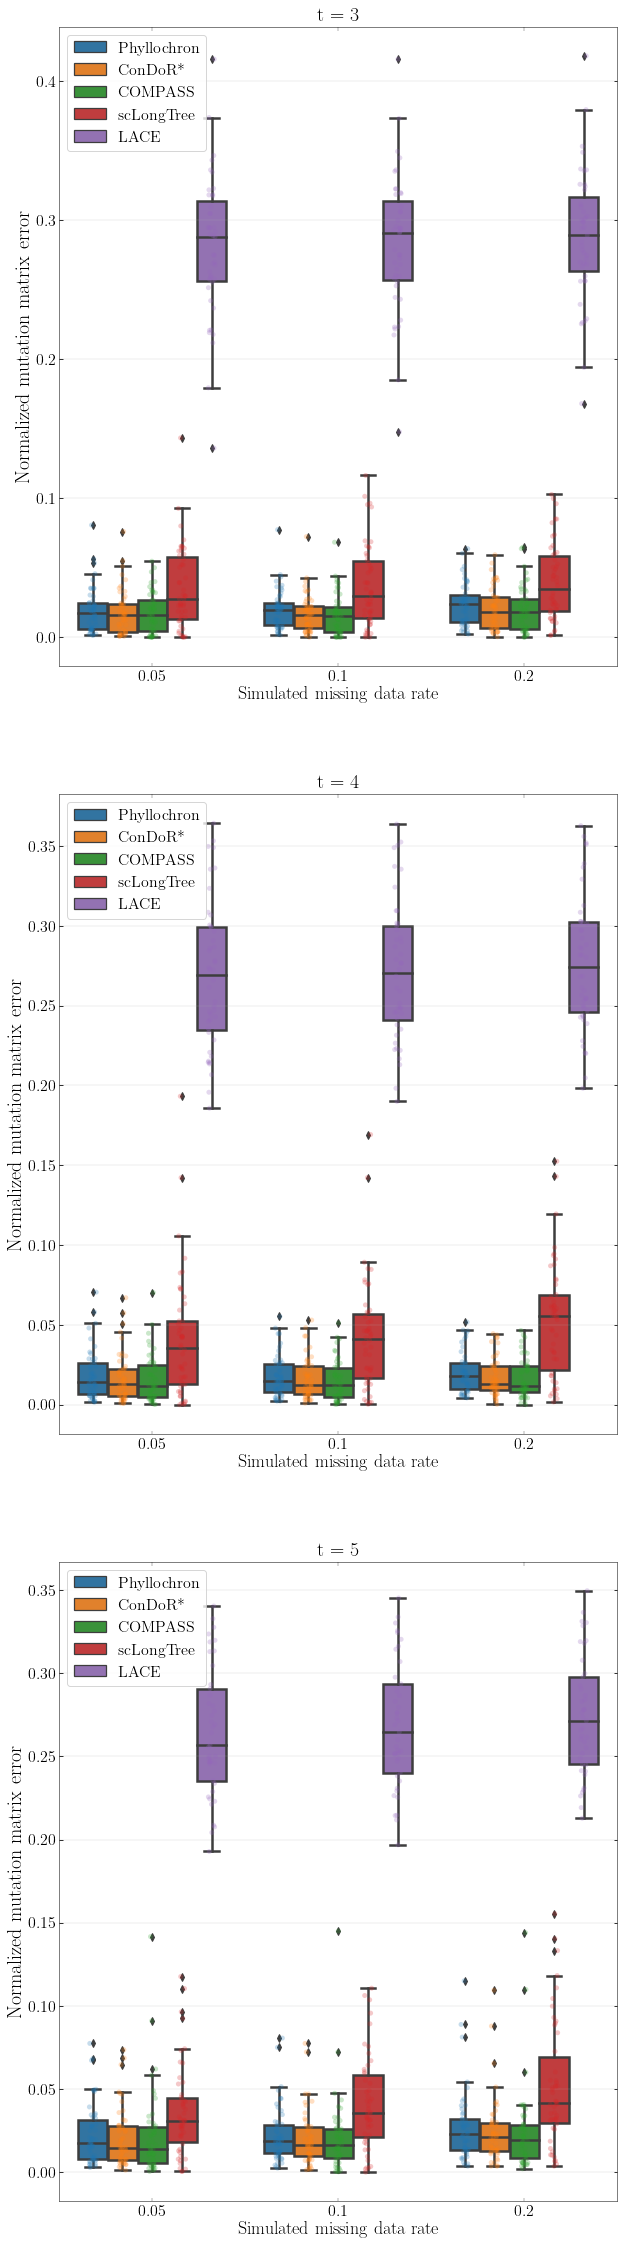

In [26]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), figsize=(10, 40))
for i, t in enumerate(timepoints):
    for k, n in enumerate(ncells_per_sample):
        print(i,k)
        all_data = []
        for j, prop in enumerate(error_rates):
            phyllochron_pp_diffs = []
            phyllochron_diffs = []
            SPhyR_diffs = []
            SCITE_diffs = []
            input_diffs = []
            Phylovar_diffs = []
            COMPASS_diffs = []
            sclongtree_diffs = []
            LACE_diffs = []

            phyllochron_pp_diffs_error = []
            phyllochron_diffs_error = []
            SPhyR_diffs_error = []
            SCITE_diffs_error = []
            input_diffs_error = []
            Phylovar_diffs_error = []
            COMPASS_diffs_error = []

            for sd in range(num_replicates + 1):
                if sd < num_replicates:
                    og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{n}_{t}_{prop}_{sd}.csv').values[:, 1:]
                    phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{n}_{t}_{prop}_{sd}_B.csv')
                    phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{n}_{t}_{prop}_{sd}_B.csv')
                    sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{n}_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                    Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{n}_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                    COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                    COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
                    df_variant = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{n}_{t}_{prop}_{sd}_variant_readcounts.csv')
                    df_total = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{n}_{t}_{prop}_{sd}_total_readcounts.csv')
                    
                    
                    if Path(f'../simulations/LACE/{n}_{t}_{prop}_{sd}_tree.RData').exists():
                        LACE_matrix = pd.read_csv(f'../simulations/LACE/{n}_{t}_{prop}_{sd}_genotype_matrix.csv', index_col=0)
                        LACE_matrix =LACE_matrix.values
                        if LACE_matrix.shape[1] == nmutations:
                            LACE_diffs.append(np.sum(np.abs(og_character_matrix - LACE_matrix))/(n * nmutations * t))
                        else:
                            LACE_diffs.append(np.nan)
                    else:
                        LACE_diffs.append(np.nan)
                    #print(sclongtree_cell_assignment)
                    gv = pgv.AGraph(f'../simulations/SCITE/scite_{n}_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                    G = nx.DiGraph(gv)
                
                    #SCITE_character_matrix = build_matrix(G, t * k, nmutations)
                    SPhyR_character_matrix = sphyr_df.values
                    sc_longtree_matrix = read_inferred_tree_longtree(f'../simulations/sclongtree/sclongtree_{n}_{t}_{prop}_{sd}.csv', n*t, nmutations)
                    phylovar_matrix = Phylovar_df.values
                    COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes, nmutations)
                    phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                    phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                    
                    #input_diffs.append(calculate_likelihood(input_character_matrix, og_character_matrix, prop))
                    #phyllochron_pp_diffs.append(calculate_likelihood(input_character_matrix,  phyllochron_pp_character_matrix, prop))
                    #phyllochron_diffs.append(calculate_likelihood(input_character_matrix, phyllochron_character_matrix, prop))
                    #SPhyR_diffs.append(calculate_likelihood(input_character_matrix, SPhyR_character_matrix, prop))
                    #SCITE_diffs.append(calculate_likelihood(input_character_matrix, SCITE_character_matrix, prop))
                    #Phylovar_diffs.append(calculate_likelihood(input_character_matrix, Phylovar_character_matrix, prop))
                    #COMPASS_diffs.append(calculate_likelihood(input_character_matrix, COMPASS_character_matrix, prop))

                    #input_diffs.append(calculate_likelihood_rc(og_character_matrix, df_variant.values, df_total.values, prop))
                    #phyllochron_pp_diffs.append(calculate_likelihood_rc(phyllochron_pp_character_matrix, df_variant.values, df_total.values,prop))
                    #phyllochron_diffs.append(calculate_likelihood_rc( phyllochron_character_matrix, df_variant.values, df_total.values,prop))
                    #SPhyR_diffs.append(calculate_likelihood_rc( SPhyR_character_matrix, df_variant.values, df_total.values,prop))
                    #SCITE_diffs.append(calculate_likelihood_rc( SCITE_character_matrix, df_variant.values, df_total.values,prop))
                    #Phylovar_diffs.append(calculate_likelihood_rc( Phylovar_character_matrix, df_variant.values, df_total.values,prop))
                    #COMPASS_diffs.append(calculate_likelihood_rc( COMPASS_character_matrix, df_variant.values, df_total.values,prop))
                    
                    SPhyR_diffs.append(np.sum(np.abs(og_character_matrix - SPhyR_character_matrix))/(n * nmutations * t))
                    #SCITE_diffs.append(np.sum(np.abs(og_character_matrix - SCITE_character_matrix))/(n * nmutations * t))
                    Phylovar_diffs.append(np.sum(np.abs(og_character_matrix - phylovar_matrix))/(n * nmutations * t))
                    sclongtree_diffs.append(np.sum(np.abs(og_character_matrix - sc_longtree_matrix))/(n * nmutations * t))
                    phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(n * nmutations * t))
                    phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(n * nmutations * t))
                    COMPASS_diffs.append(np.sum(np.abs(og_character_matrix - COMPASS_character_matrix))/(n * nmutations * t))
            data = pd.DataFrame({'Simulated sequencing error rate': (5*num_replicates)*[prop],'Type':  num_replicates*['Phyllochron'] + num_replicates*['ConDoR*'] + num_replicates*['COMPASS'] + num_replicates*['scLongTree'] + num_replicates*['LACE'],'Normalized Mutation Matrix Error':phyllochron_diffs + phyllochron_pp_diffs +  COMPASS_diffs + sclongtree_diffs + LACE_diffs})
            all_data.append(data)

        axs[i].set_title(f't = {t}', fontsize=20)
        #axs[i].set_ylim(-0.00, 0.125)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.stripplot(data=data_final, x='Simulated sequencing error rate', y="Normalized Mutation Matrix Error", hue="Type", alpha=0.25, dodge=True, ax=axs[i])
        sns.boxplot(data=data_final, x='Simulated sequencing error rate', y="Normalized Mutation Matrix Error", hue="Type",  ax=axs[i])

        axs[i].tick_params(axis="x", labelsize=16)
        axs[i].tick_params(axis="y", labelsize=16)

        axs[i].set_xlabel('Simulated missing data rate', fontsize=18)
        axs[i].set_ylabel('Normalized mutation matrix error', fontsize=20)


for i in range(axs.shape[0]):
    remove_duplicate_legend_entries(axs[i])
plt.show()

In [218]:
print(np.mean(data_final[(data_final["Type"]=="COMPASS") & (data_final["Simulated sequencing error rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="LACE") & (data_final["Simulated sequencing error rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="scLongTree") & (data_final["Simulated sequencing error rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="ConDoR*") & (data_final["Simulated sequencing error rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="Phyllochron") & (data_final["Simulated sequencing error rate"]==0.10)]))


Simulated sequencing error rate     0.10000
Normalized Mutation Matrix Error    0.02118
dtype: float64
Simulated sequencing error rate     0.100000
Normalized Mutation Matrix Error    0.268634
dtype: float64
Simulated sequencing error rate     0.10000
Normalized Mutation Matrix Error    0.04118
dtype: float64
Simulated sequencing error rate     0.100000
Normalized Mutation Matrix Error    0.020496
dtype: float64
Simulated sequencing error rate     0.100000
Normalized Mutation Matrix Error    0.022476
dtype: float64


/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


## Plot Clonal Lifespan Accuracy

0 0
1 0
2 0


<Figure size 432x288 with 0 Axes>

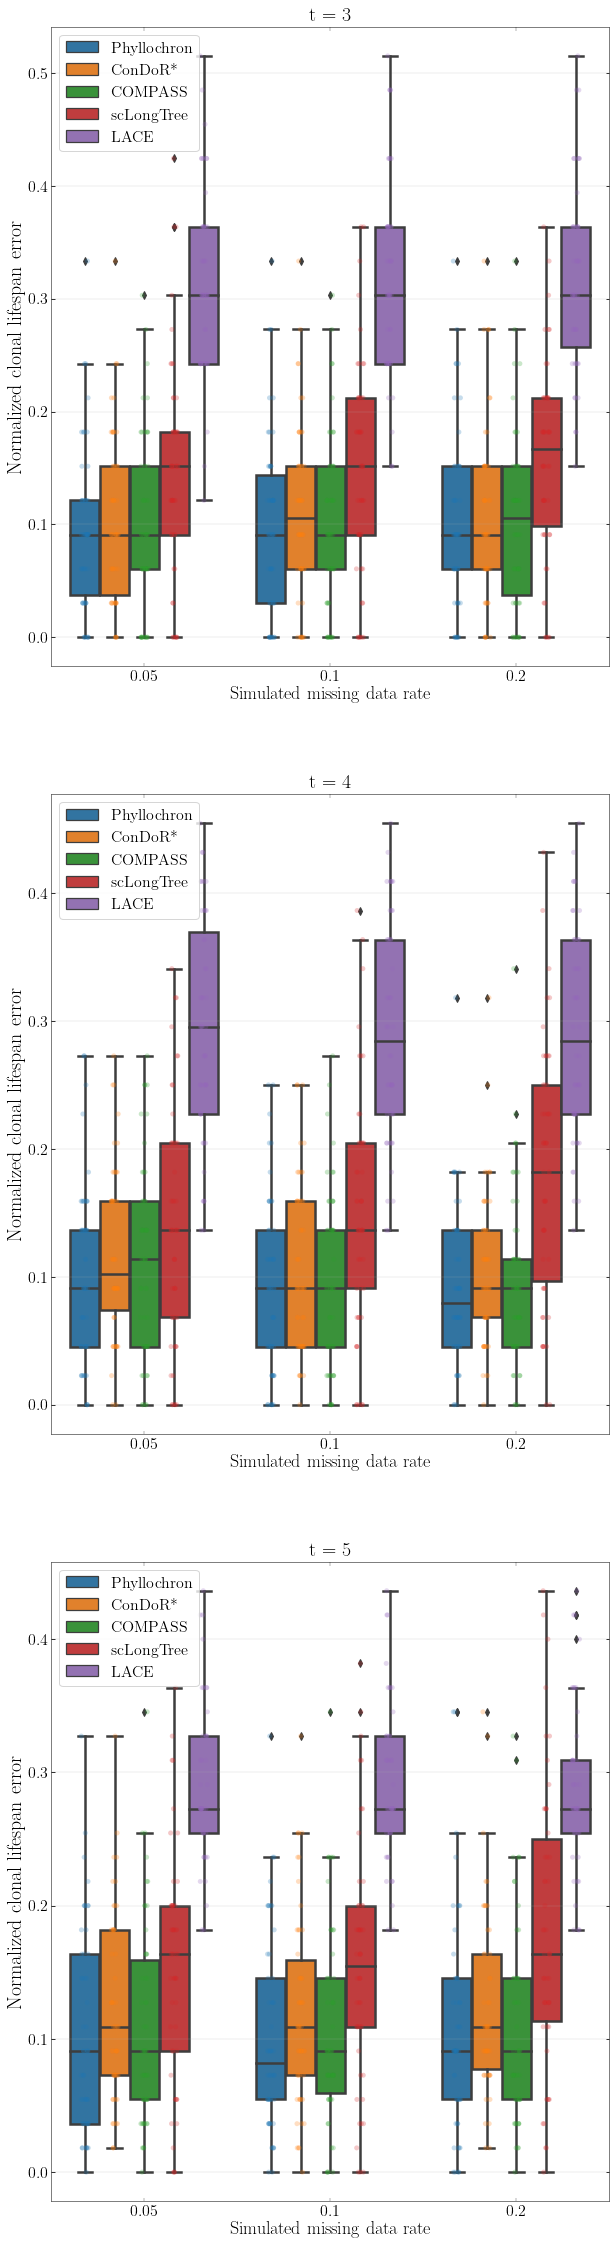

In [27]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), figsize=(10, 40))
for i, t in enumerate(timepoints):
    for k, n in enumerate(ncells_per_sample):
        print(i,k)
        all_data = []
        for j, prop in enumerate(error_rates):
            phyllochron_pp_diffs = []
            phyllochron_diffs = []
            SPhyR_diffs = []
            SCITE_diffs = []
            input_diffs = []
            Phylovar_diffs = []
            COMPASS_diffs = []
            sclongtree_diffs = []
            LACE_diffs = []

            phyllochron_pp_diffs_error = []
            phyllochron_diffs_error = []
            SPhyR_diffs_error = []
            SCITE_diffs_error = []
            input_diffs_error = []
            Phylovar_diffs_error = []
            COMPASS_diffs_error = []

            for sd in range(num_replicates + 1):
                if sd < num_replicates:
                    og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{n}_{t}_{prop}_{sd}.csv').values[:, 1:]
                    original_map = defaultdict(set)
                    timepoint_count = defaultdict()
                    for r in range(og_character_matrix.shape[0]):
                        if " ".join(map(str, map(int, og_character_matrix[r]))) not in timepoint_count.keys():
                            timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))] = defaultdict(int)
                        timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//n] += 1
                        if timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//n] >= 0:
                            original_map[" ".join(map(str, map(int, og_character_matrix[r])))].add(r//n)
                            
                            
                    phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{n}_{t}_{prop}_{sd}_B.csv')
                    phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{n}_{t}_{prop}_{sd}_B.csv')
                    sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{n}_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                    Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{n}_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                    COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                    COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
                    df_variant = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{n}_{t}_{prop}_{sd}_variant_readcounts.csv')
                    df_total = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{n}_{t}_{prop}_{sd}_total_readcounts.csv')
                    
                    
                    if Path(f'../simulations/LACE/{n}_{t}_{prop}_{sd}_tree.RData').exists():
                        LACE_matrix = pd.read_csv(f'../simulations/LACE/{n}_{t}_{prop}_{sd}_genotype_matrix.csv', index_col=0)
                        LACE_matrix =LACE_matrix.values
                        if LACE_matrix.shape[1] == nmutations:
                            LACE_diffs.append(clonal_accuracy(original_map, LACE_matrix, n, opt=(n*t)/(nmutations + 1))/((nmutations + 1) * t))
                        else:
                            LACE_diffs.append(np.nan)
                    else:
                        LACE_diffs.append(np.nan)
                    #print(sclongtree_cell_assignment)
                    gv = pgv.AGraph(f'../simulations/SCITE/scite_{n}_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                    G = nx.DiGraph(gv)
                
                    #SCITE_character_matrix = build_matrix(G, t * k, nmutations)
                    SPhyR_character_matrix = sphyr_df.values
                    sc_longtree_matrix = read_inferred_tree_longtree(f'../simulations/sclongtree/sclongtree_{n}_{t}_{prop}_{sd}.csv', n*t, nmutations)
                    phylovar_matrix = Phylovar_df.values
                    COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes, nmutations)
                    phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                    phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                    
                    #input_diffs.append(calculate_likelihood(input_character_matrix, og_character_matrix, prop))
                    #phyllochron_pp_diffs.append(calculate_likelihood(input_character_matrix,  phyllochron_pp_character_matrix, prop))
                    #phyllochron_diffs.append(calculate_likelihood(input_character_matrix, phyllochron_character_matrix, prop))
                    #SPhyR_diffs.append(calculate_likelihood(input_character_matrix, SPhyR_character_matrix, prop))
                    #SCITE_diffs.append(calculate_likelihood(input_character_matrix, SCITE_character_matrix, prop))
                    #Phylovar_diffs.append(calculate_likelihood(input_character_matrix, Phylovar_character_matrix, prop))
                    #COMPASS_diffs.append(calculate_likelihood(input_character_matrix, COMPASS_character_matrix, prop))

                    #input_diffs.append(calculate_likelihood_rc(og_character_matrix, df_variant.values, df_total.values, prop))
                    #phyllochron_pp_diffs.append(calculate_likelihood_rc(phyllochron_pp_character_matrix, df_variant.values, df_total.values,prop))
                    #phyllochron_diffs.append(calculate_likelihood_rc( phyllochron_character_matrix, df_variant.values, df_total.values,prop))
                    #SPhyR_diffs.append(calculate_likelihood_rc( SPhyR_character_matrix, df_variant.values, df_total.values,prop))
                    #SCITE_diffs.append(calculate_likelihood_rc( SCITE_character_matrix, df_variant.values, df_total.values,prop))
                    #Phylovar_diffs.append(calculate_likelihood_rc( Phylovar_character_matrix, df_variant.values, df_total.values,prop))
                    #COMPASS_diffs.append(calculate_likelihood_rc( COMPASS_character_matrix, df_variant.values, df_total.values,prop))
                    
                    
                    phyllochron_pp_diffs.append(clonal_accuracy(original_map, phyllochron_pp_character_matrix, n, opt=(n*t)/(nmutations + 1))/((nmutations + 1) * t))
                    phyllochron_diffs.append(clonal_accuracy(original_map , phyllochron_character_matrix, n,opt=(n*t)/(nmutations + 1))/((nmutations + 1) * t))
                    COMPASS_diffs.append(clonal_accuracy(original_map , COMPASS_character_matrix, n, opt=(n*t)/(nmutations + 1))/((nmutations + 1) * t))
                    SPhyR_diffs.append(clonal_accuracy(original_map , SPhyR_character_matrix, n,  opt=(n*t)/(nmutations + 1))/((nmutations + 1) * t))
                    Phylovar_diffs.append(clonal_accuracy(original_map , phylovar_matrix, n,  opt=(n*t)/(nmutations + 1))/((nmutations + 1) * t))
                    sclongtree_diffs.append(clonal_accuracy(original_map , sc_longtree_matrix, n,  opt=(n*t)/(nmutations + 1))/((nmutations + 1) * t))

            data = pd.DataFrame({'Simulated sequencing error rate': (5*num_replicates)*[prop],'Type': num_replicates*['Phyllochron'] + num_replicates*['ConDoR*'] +  num_replicates*['COMPASS'] + num_replicates*['scLongTree'] + num_replicates*['LACE'],'Normalized Mutation Matrix Error':phyllochron_diffs + phyllochron_pp_diffs +  COMPASS_diffs + sclongtree_diffs + LACE_diffs})
            all_data.append(data)

        axs[i].set_title(f't = {t}', fontsize=20)
        #axs[i].set_ylim(-0.00, 0.125)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.stripplot(data=data_final, x='Simulated sequencing error rate', y="Normalized Mutation Matrix Error", hue="Type", alpha=0.25, dodge=True, ax=axs[i])
        sns.boxplot(data=data_final, x='Simulated sequencing error rate', y="Normalized Mutation Matrix Error", hue="Type",  ax=axs[i])

        axs[i].tick_params(axis="x", labelsize=16)
        axs[i].tick_params(axis="y", labelsize=16)

        axs[i].set_xlabel('Simulated missing data rate', fontsize=18)
        axs[i].set_ylabel('Normalized clonal lifespan error', fontsize=20)


for i in range(axs.shape[0]):
    remove_duplicate_legend_entries(axs[i])
plt.show()

In [196]:
def ppm_to_tree(matrix):
    matrix = np.unique(matrix, axis=0)
    matrix = matrix[np.argsort(np.sum(matrix == 1, axis=1))]
    root = ete3.Tree()
    ancestral_chars = [c for c in range(matrix.shape[1]) if sum(matrix[:,c]) == 0]
    poset = []
    init_len = len(ancestral_chars)

    while len(ancestral_chars) < matrix.shape[1]:
        for char in range(matrix.shape[1]):
            if char not in ancestral_chars:
                for row in range(matrix.shape[0]):
                    if matrix[row, char] == 1:
                        if all([matrix[row, c] == 0 for c in range(matrix.shape[1]) if c != char and c not in ancestral_chars]):
                            all_anc = [c for c in ancestral_chars if matrix[row,c] == 1]
                            if len(all_anc) == 0:
                                d_anc = root
                            else:
                                d_anc = root.search_nodes(name=str(all_anc[-1]))[0]
                            
                            nchild = d_anc.add_child(name=str(char))
                            poset.append(char)
                            ancestral_chars.append(char)
                            break
        
        if len(ancestral_chars) == init_len:
            for char in range(matrix.shape[1]):
                if char not in ancestral_chars:
                    for row in range(matrix.shape[0]):
                        if matrix[row, char] == 1:
                            all_anc = [c for c in ancestral_chars if matrix[row,c] == 1]
                            if len(all_anc) == 0:
                                d_anc = root
                            else:
                                d_anc = root.search_nodes(name=str(all_anc[-1]))[0]

                            nchild = d_anc.add_child(name=str(char))
                            poset.append(char)
                            ancestral_chars.append(char)
                            break
        
        init_len = len(ancestral_chars)

    return root

In [220]:
print(np.mean(data_final[(data_final["Type"]=="COMPASS") & (data_final["Simulated sequencing error rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="LACE") & (data_final["Simulated sequencing error rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="scLongTree") & (data_final["Simulated sequencing error rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="ConDoR*") & (data_final["Simulated sequencing error rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="Phyllochron") & (data_final["Simulated sequencing error rate"]==0.10)]))


Simulated sequencing error rate     0.100000
Normalized Mutation Matrix Error    0.106909
dtype: float64
Simulated sequencing error rate     0.100000
Normalized Mutation Matrix Error    0.292683
dtype: float64
Simulated sequencing error rate     0.100000
Normalized Mutation Matrix Error    0.154545
dtype: float64
Simulated sequencing error rate     0.10
Normalized Mutation Matrix Error    0.12
dtype: float64
Simulated sequencing error rate     0.100000
Normalized Mutation Matrix Error    0.101818
dtype: float64


/n/fs/ragr-data/users/aj7381/anaconda3/envs/mamba/envs/jupyter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0 0
1 0
2 0


<Figure size 432x288 with 0 Axes>

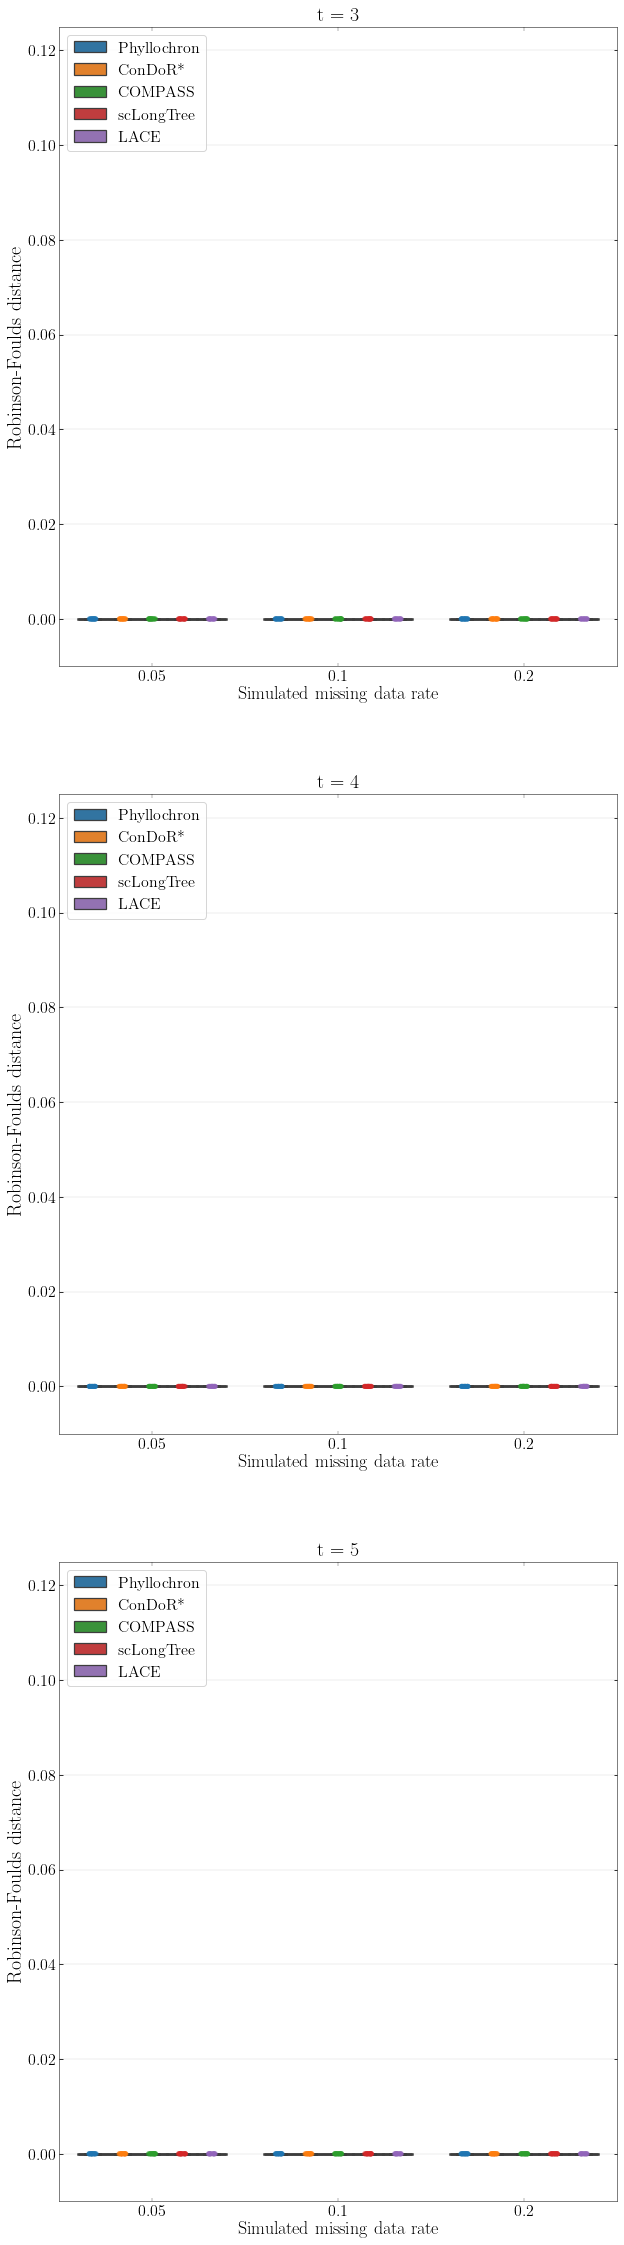

In [33]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), figsize=(10, 40))
for i, t in enumerate(timepoints):
    for k, n in enumerate(ncells_per_sample):
        print(i,k)
        all_data = []
        for j, prop in enumerate(error_rates):
            phyllochron_pp_diffs = []
            phyllochron_diffs = []
            SPhyR_diffs = []
            SCITE_diffs = []
            input_diffs = []
            Phylovar_diffs = []
            COMPASS_diffs = []
            sclongtree_diffs = []
            LACE_diffs = []

            phyllochron_pp_diffs_error = []
            phyllochron_diffs_error = []
            SPhyR_diffs_error = []
            SCITE_diffs_error = []
            input_diffs_error = []
            Phylovar_diffs_error = []
            COMPASS_diffs_error = []

            for sd in range(num_replicates + 1):
                if sd < num_replicates:
                    og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{n}_{t}_{prop}_{sd}.csv').values[:, 1:]
                    phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{n}_{t}_{prop}_{sd}_B.csv')
                    phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{n}_{t}_{prop}_{sd}_B.csv')
                    sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{n}_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                    Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{n}_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                    COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                    COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
                    df_variant = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{n}_{t}_{prop}_{sd}_variant_readcounts.csv')
                    df_total = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{n}_{t}_{prop}_{sd}_total_readcounts.csv')
                    
                    
                    if Path(f'../simulations/LACE/{n}_{t}_{prop}_{sd}_tree.RData').exists():
                        LACE_matrix = pd.read_csv(f'../simulations/LACE/{n}_{t}_{prop}_{sd}_genotype_matrix.csv', index_col=0)
                        LACE_matrix =LACE_matrix.values
                        if LACE_matrix.shape[1] == nmutations:
                            LACE_diffs.append(ppm_to_tree(og_character_matrix).robinson_foulds(ppm_to_tree(LACE_matrix),  unrooted_trees=True)[0])
                        else:
                            LACE_diffs.append(np.nan)
                    else:
                        LACE_diffs.append(np.nan)
                    #print(sclongtree_cell_assignment)
                    gv = pgv.AGraph(f'../simulations/SCITE/scite_{n}_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                    G = nx.DiGraph(gv)
                
                    #SCITE_character_matrix = build_matrix(G, t * k, nmutations)
                    SPhyR_character_matrix = sphyr_df.values
                    

                    sc_longtree_matrix = read_inferred_tree_longtree(f'../simulations/sclongtree/sclongtree_{n}_{t}_{prop}_{sd}.csv', n*t, nmutations)
                    phylovar_matrix = Phylovar_df.values
                    COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes, nmutations)
                    phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                    phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                    
                
                    
                    phyllochron_pp_diffs.append(ppm_to_tree(og_character_matrix).robinson_foulds(ppm_to_tree(phyllochron_pp_character_matrix),  unrooted_trees=True)[0])
                    phyllochron_diffs.append(ppm_to_tree(og_character_matrix).robinson_foulds(ppm_to_tree(phyllochron_character_matrix),  unrooted_trees=True)[0])
                    COMPASS_diffs.append(ppm_to_tree(og_character_matrix).robinson_foulds(ppm_to_tree(COMPASS_character_matrix),  unrooted_trees=True)[0])
                    SPhyR_diffs.append(ppm_to_tree(og_character_matrix).robinson_foulds(ppm_to_tree(SPhyR_character_matrix),  unrooted_trees=True)[0])
                    Phylovar_diffs.append(ppm_to_tree(og_character_matrix).robinson_foulds(ppm_to_tree(phylovar_matrix),  unrooted_trees=True)[0])
                    
                    
                    
                   
                    sclongtree_diffs.append(ppm_to_tree(og_character_matrix).robinson_foulds(ppm_to_tree(sc_longtree_matrix), unrooted_trees=True)[0])

            data = pd.DataFrame({'Simulated sequencing error rate': (5*num_replicates)*[prop],'Type':num_replicates*['Phyllochron'] + num_replicates*['ConDoR*'] +  num_replicates*['COMPASS'] + num_replicates*['scLongTree'] +  num_replicates*['LACE'],'Normalized Mutation Matrix Error':phyllochron_diffs + phyllochron_pp_diffs +  COMPASS_diffs + sclongtree_diffs + LACE_diffs})
            all_data.append(data)

        axs[i].set_title(f't = {t}', fontsize=20)
        axs[i].set_ylim(-0.01, 0.125)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.stripplot(data=data_final, x='Simulated sequencing error rate', y="Normalized Mutation Matrix Error", hue="Type", alpha=0.25, dodge=True, ax=axs[i])
        sns.boxplot(data=data_final, x='Simulated sequencing error rate', y="Normalized Mutation Matrix Error", hue="Type",  ax=axs[i])

        axs[i].tick_params(axis="x", labelsize=16)
        axs[i].tick_params(axis="y", labelsize=16)

        axs[i].set_xlabel('Simulated missing data rate', fontsize=18)
        axs[i].set_ylabel('Robinson-Foulds distance', fontsize=20)


for i in range(axs.shape[0]):
    remove_duplicate_legend_entries(axs[i])
plt.show()

0 0


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1800x1200 with 0 Axes>

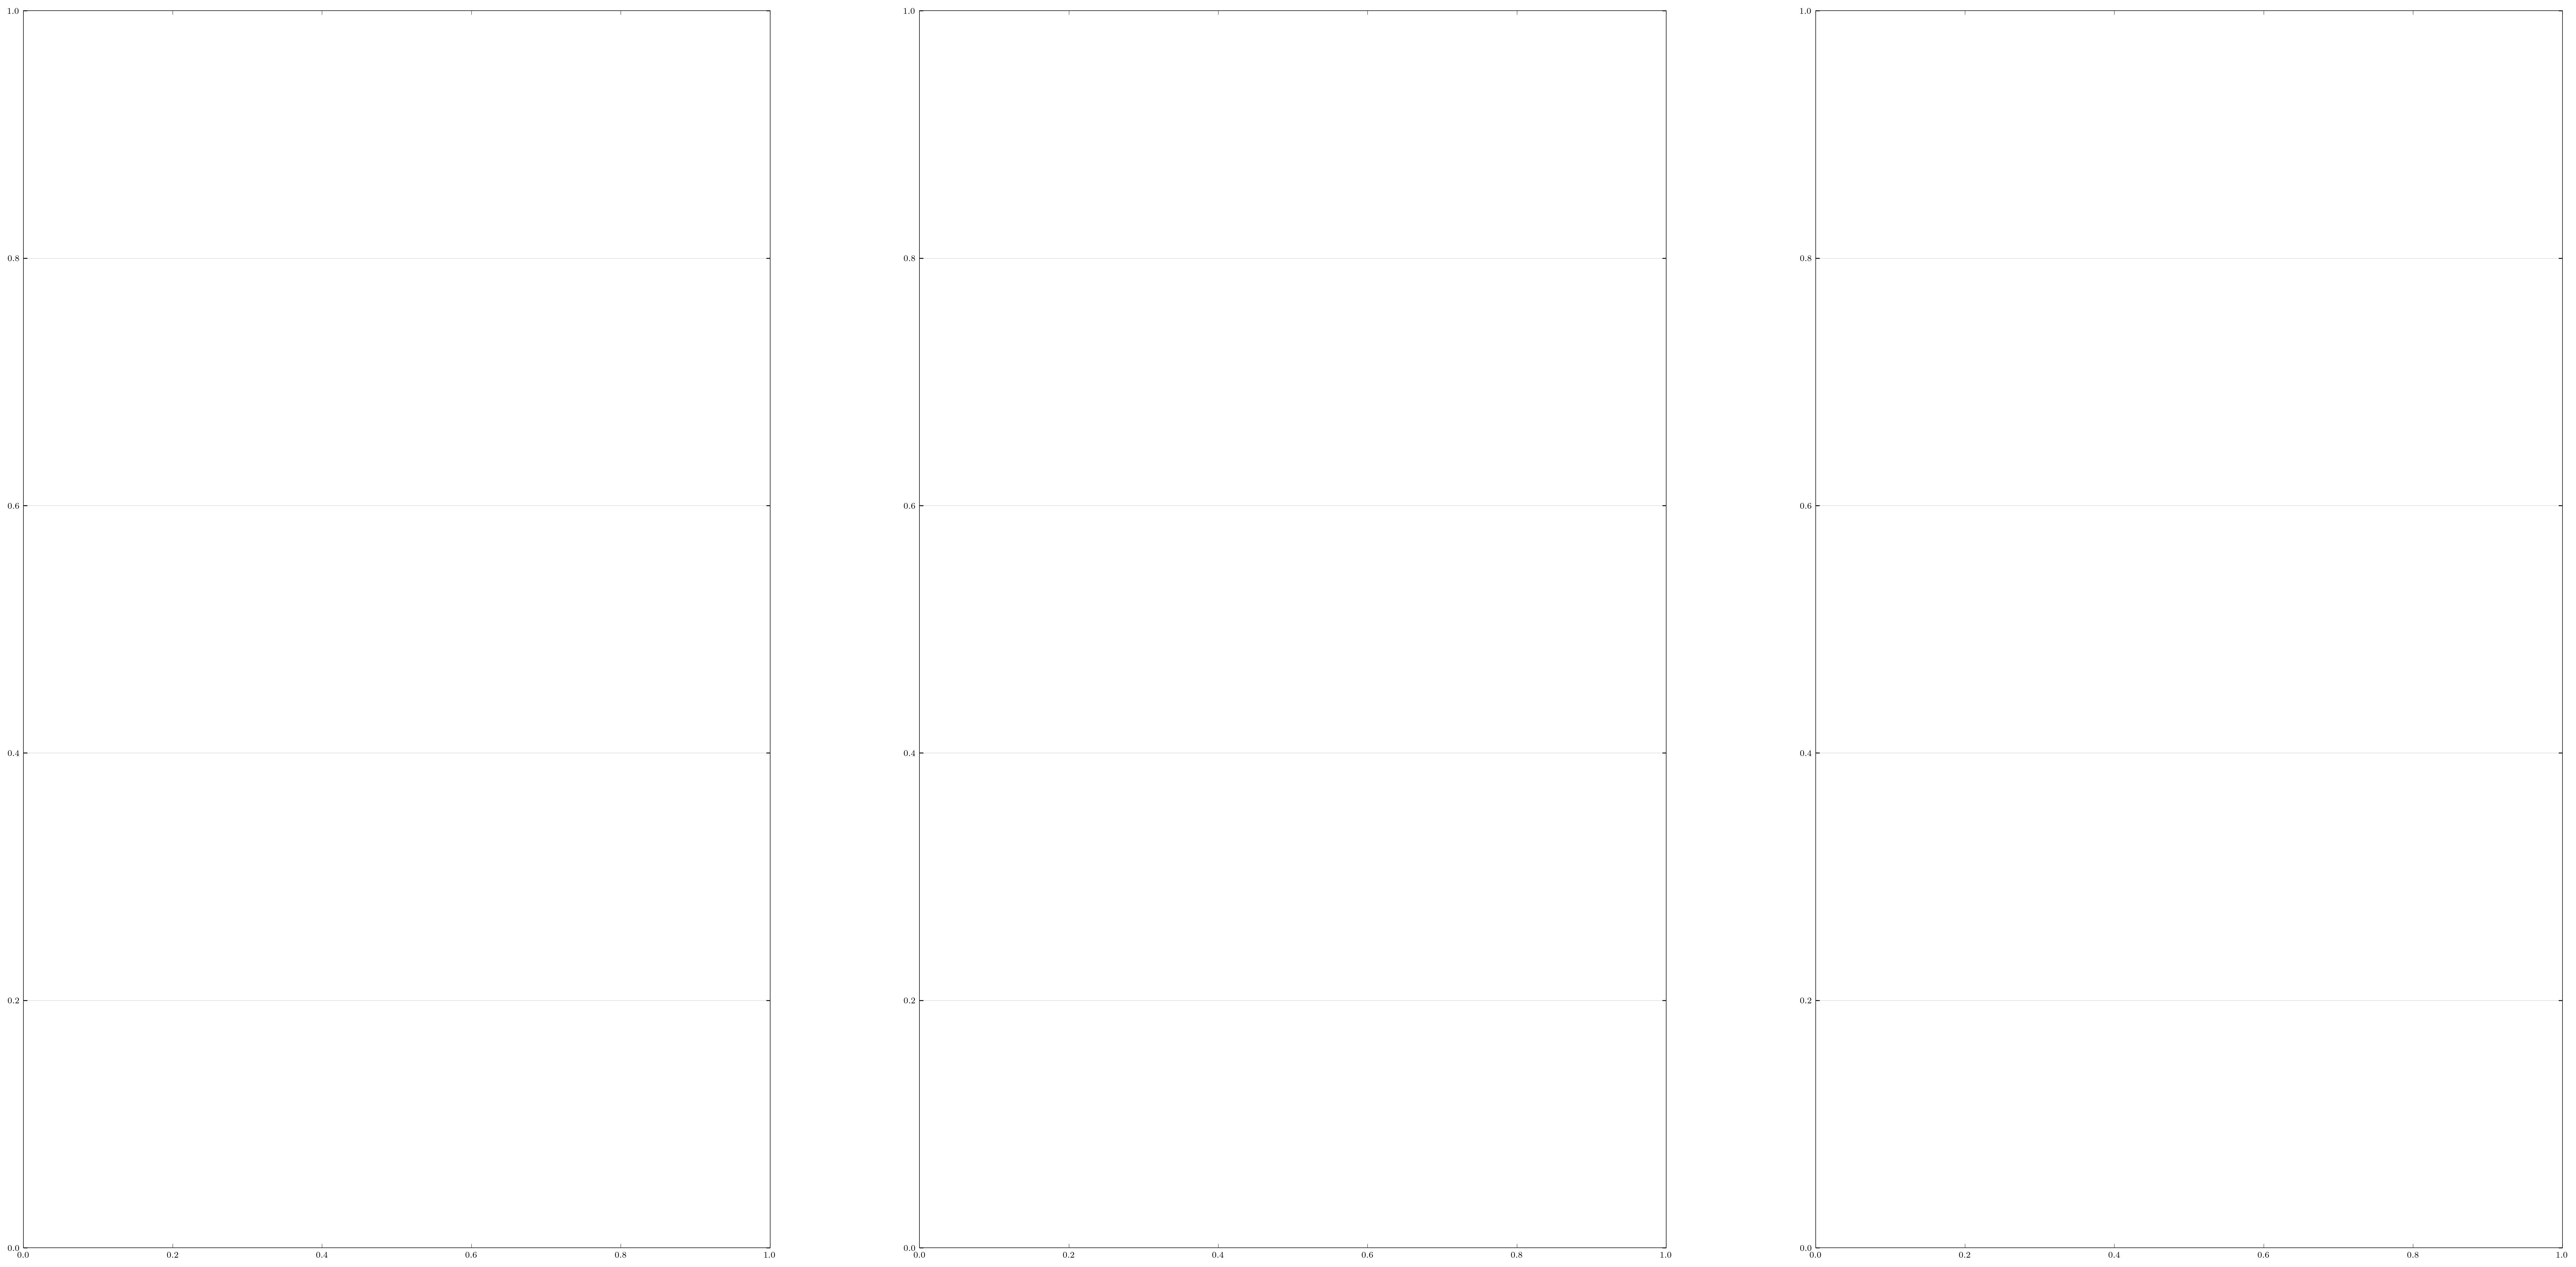

In [198]:
plt.figure()
fig, axs = plt.subplots(len(ncells_per_sample[:]), len(timepoints), figsize=(42, 21))
for i, t in enumerate(timepoints):
    for k, n in enumerate(ncells_per_sample[:]):
        print(i,k)
        all_data = []
        for j, prop in enumerate(error_rates):
            phyllochron_pp_diffs = []
            phyllochron_diffs = []
            Phylovar_diffs = []
            COMPASS_diffs = []
            SPhyR_diffs = []
            SCITE_diffs = []
            for sd in range(num_replicates + 1):
                if sd < num_replicates:
                    og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{n}_{t}_{prop}_{sd}.csv').values[:, 1:]
                    original_map = defaultdict(set)
                    timepoint_count = defaultdict()
                    for r in range(og_character_matrix.shape[0]):
                        if " ".join(map(str, map(int, og_character_matrix[r]))) not in timepoint_count.keys():
                            timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))] = defaultdict(int)
                        timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//n] += 1
                        if timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//n] >= 0:
                            original_map[" ".join(map(str, map(int, og_character_matrix[r])))].add(r//n)

                    phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{n}_{t}_{prop}_{sd}_B.csv')
                    phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{n}_{t}_{prop}_{sd}_B.csv')
                    COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                    COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')

                    phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                    phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                    #Phylovar_character_matrix = Phylovar_df.values
                    COMPASS_character_matrix = build_compass_matrix_fast(COMPASS_cell_assignment, COMPASS_genotypes, nmutations)

                    phyllochron_pp_diffs.append(clonal_accuracy(original_map, phyllochron_pp_character_matrix, n, opt=1)/(np.unique(phyllochron_pp_character_matrix, axis=0).shape[0] * t))
                    phyllochron_diffs.append(clonal_accuracy(original_map , phyllochron_character_matrix, n,opt=1)/(np.unique(phyllochron_character_matrix, axis=0).shape[0] * t))
                    COMPASS_diffs.append(clonal_accuracy(original_map , COMPASS_character_matrix, n, opt=1)/(np.unique(COMPASS_character_matrix, axis=0).shape[0] * t))



            data = pd.DataFrame({'Error Rate': (3*num_replicates)*[prop],'Type': num_replicates*['ConDoR*'] + num_replicates*['Phyllochron'] + num_replicates*['COMPASS'] ,'Normalized Clone Lifespan Error':phyllochron_pp_diffs + phyllochron_diffs + COMPASS_diffs})
            all_data.append(data)

        axs[k,i].set_title(f't = {t}')
        #axs[i,k].set_ylim(-0.00, 1.00)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.stripplot(data=data_final, x='Error Rate', y="Normalized Clone Lifespan Error", alpha=0.5, dodge=True, hue="Type", ax=axs[k,i])
        sns.boxplot(data=data_final, x='Error Rate', y="Normalized Clone Lifespan Error", hue="Type", ax=axs[k,i])
        
        axs[k,i].tick_params(axis="x", labelsize=16)
        axs[k,i].tick_params(axis="y", labelsize=16)

        axs[k,i].set_xlabel('Simulated missing data rate', fontsize=20)
        axs[k,i].set_ylabel('Normalized clone lifespan error', fontsize=22)


for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        remove_duplicate_legend_entries(axs[i,j])
plt.tight_layout()
plt.show()


In [ ]:
plt.figure()
fig, axs = plt.subplots(len(ncells_per_sample), len(timepoints), figsize=(42, 21))
for i, t in enumerate(timepoints):
    for k, n in enumerate(ncells_per_sample):
        print(i,k)
        all_data = []
        for j, prop in enumerate(error_rates):
            phyllochron_pp_diffs = []
            phyllochron_diffs = []
            gt_diffs = []
            COMPASS_diffs = []

            for sd in range(num_replicates + 1):
                if sd < num_replicates:
                    og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{n}_{t}_{prop}_{sd}.csv').values[:, 1:]
                    #print(np.unique(og_character_matrix, axis=0))
                    #print()
                    phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{n}_{t}_{prop}_{sd}_B.csv')
                    phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{n}_{t}_{prop}_{sd}_B.csv')
                    COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                    COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{n}_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')

                    phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                    phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                    COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes, nmutations)


                    size = [n for i in range(t)]
                    phyllochron_pp_diffs.append(int(is_longitudinally_consistent_val(phyllochron_pp_character_matrix, size, verbose=False)))
                    phyllochron_diffs.append(int(is_longitudinally_consistent_val(phyllochron_character_matrix, size, verbose=True)))
                    if phyllochron_diffs[-1] > 0:
                        print(np.unique(phyllochron_character_matrix, axis=0))
                        print(f'../simulations/Phyllochron_RC/phyllochron_{n}_{t}_{prop}_{sd}_B.csv')
                    #phyllochron_diffs.append(0)
                    COMPASS_diffs.append(int(is_longitudinally_consistent_val(COMPASS_character_matrix, size, verbose=False)))
                    gt_diffs.append(int(is_longitudinally_consistent_val(og_character_matrix, size, verbose=False)))

            data = pd.DataFrame({'Error Rate': (4*num_replicates)*[prop],'Type': num_replicates*['ConDoR*'] + num_replicates*['Phyllochron'] + num_replicates*['COMPASS']+ num_replicates*['Ground Truth'] ,'Normalized Clone Lifespan Error':phyllochron_pp_diffs + phyllochron_diffs + COMPASS_diffs + gt_diffs})
            all_data.append(data)

        axs[k,i].set_title(f't = {t}')
        #axs[i].set_ylim(-0.00, 1.10)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.stripplot(data=data_final, x='Error Rate', y="Normalized Clone Lifespan Error", alpha=0.5, hue="Type",dodge=True, ax=axs[k,i])
        sns.boxplot(data=data_final, x='Error Rate', y="Normalized Clone Lifespan Error", hue="Type", ax=axs[k,i])

        axs[k,i].tick_params(axis="x", labelsize=16)
        axs[k,i].tick_params(axis="y", labelsize=16)

        axs[k,i].set_xlabel('Simulated missing data rate', fontsize=20)
        axs[k,i].set_ylabel('Number of longitudinal violations', fontsize=22)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        remove_duplicate_legend_entries(axs[i,j])

plt.tight_layout()
plt.show()


In [309]:
print(np.mean(data_final[(data_final["Type"]=="COMPASS") & (data_final["Error Rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="PhyloVar") & (data_final["Error Rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="SCITE") & (data_final["Error Rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="SPhyR") & (data_final["Error Rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="ConDoR*") & (data_final["Error Rate"]==0.10)]))
print(np.mean(data_final[(data_final["Type"]=="Phyllochron") & (data_final["Error Rate"]==0.10)]))


Error Rate                         0.10000
Normalized Clone Lifespan Error    0.32619
dtype: float64
Error Rate                         0.10000
Normalized Clone Lifespan Error    0.49881
dtype: float64
Error Rate                         0.100000
Normalized Clone Lifespan Error    0.508333
dtype: float64
Error Rate                         0.100000
Normalized Clone Lifespan Error    0.504762
dtype: float64
Error Rate                         0.100
Normalized Clone Lifespan Error    0.225
dtype: float64
Error Rate                         0.100000
Normalized Clone Lifespan Error    0.104762
dtype: float64


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


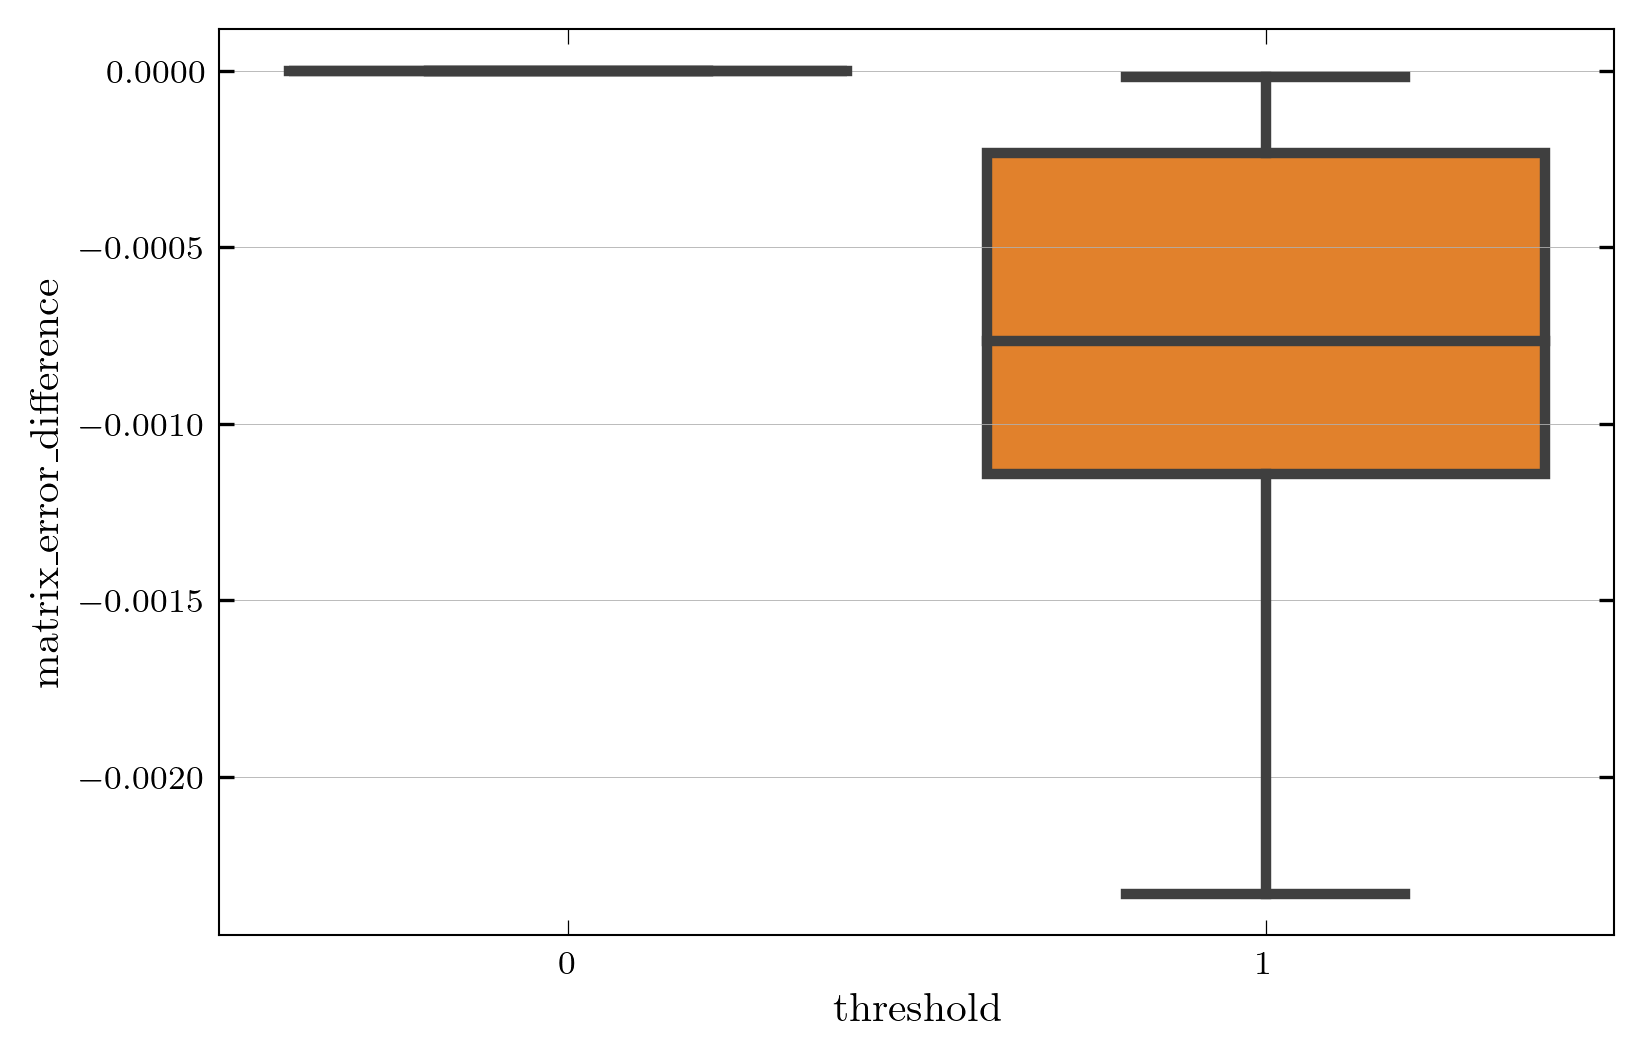

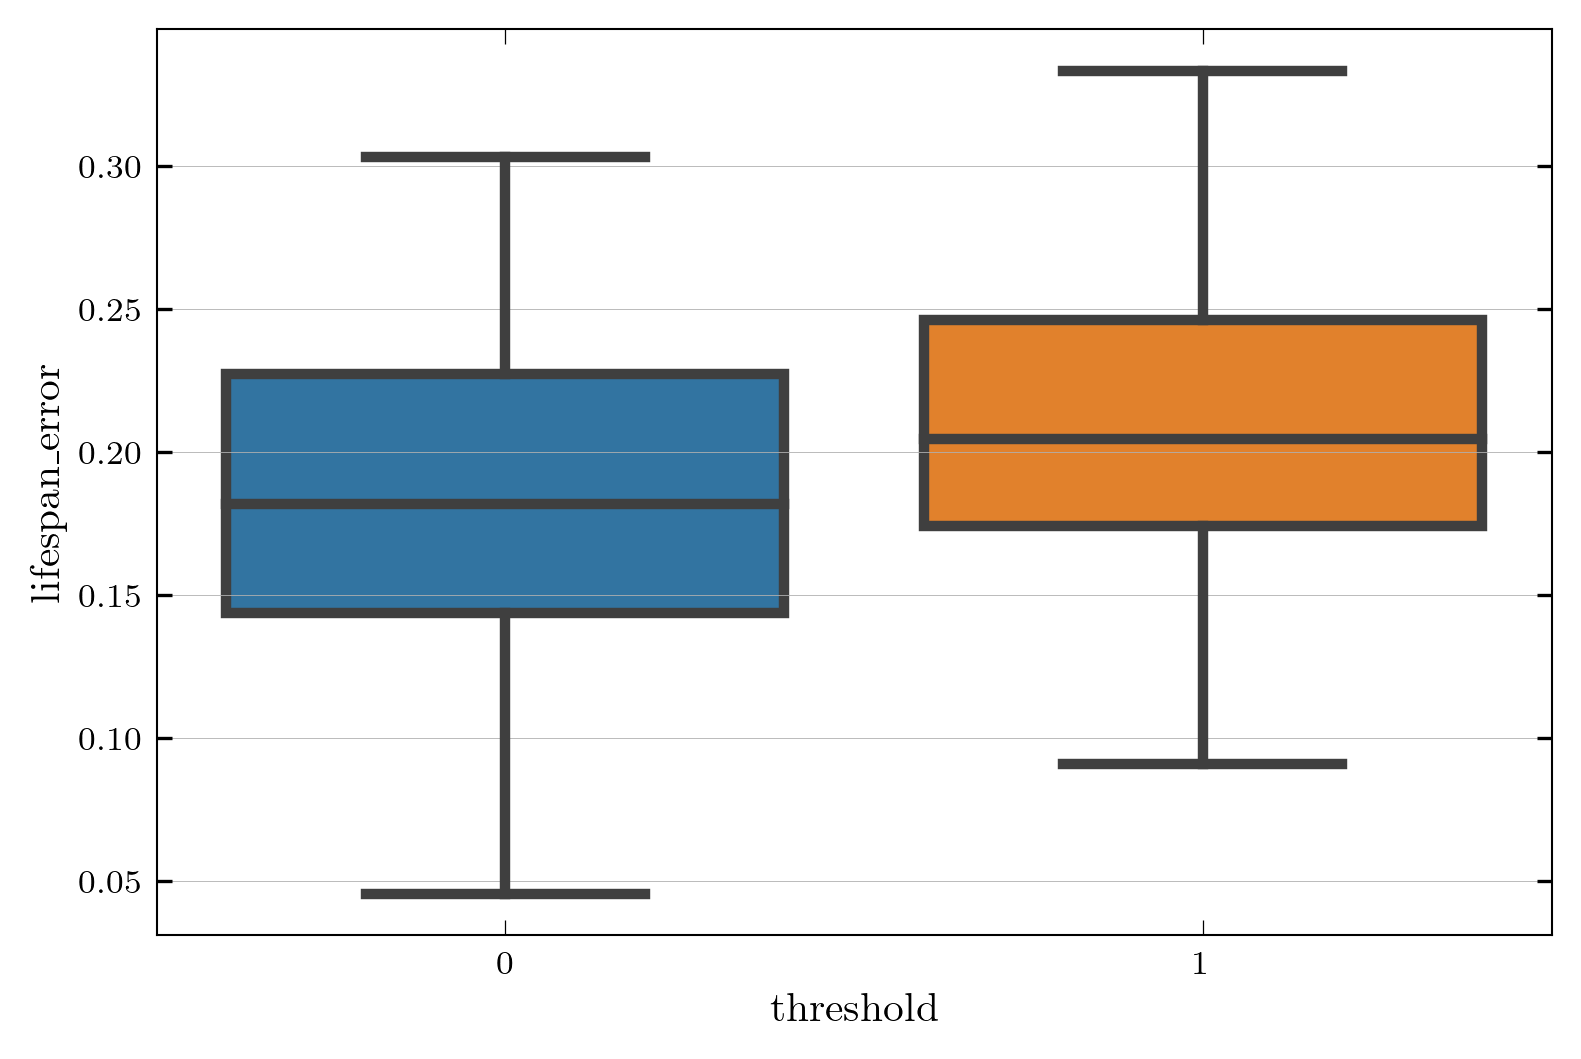

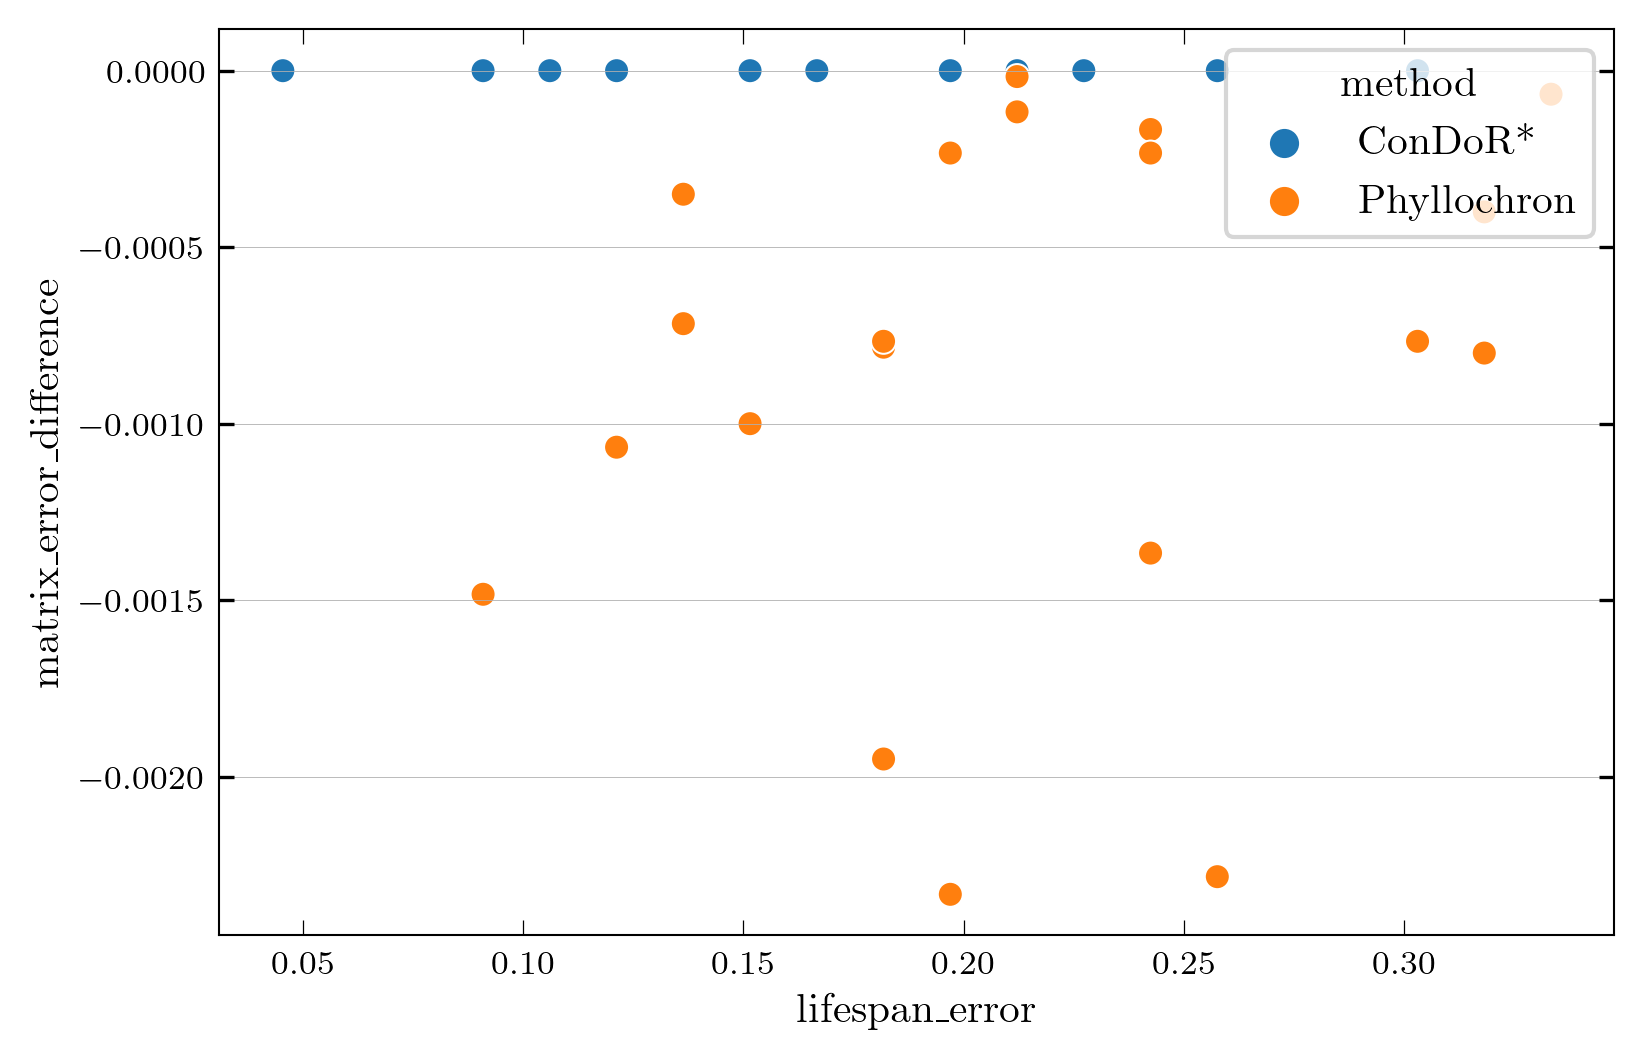

In [616]:
n = 1000
t = 6
prop=0.20
nmutations = 10

plt.figure()

data_final = {"threshold":[], "lifespan_error":[], "matrix_error":[], "matrix_error_difference": [], "method": []}




for s in range(20):
    print(s)

    sd=s
    og_character_matrix = pd.read_csv(f'../simulations/cell_threshold_sweep/ground_truth_rc/gt_readcount_{n}_{t}_{prop}_{sd}.csv').values[:, 1:]
    original_map = defaultdict(set)
    timepoint_count = defaultdict()
    for r in range(og_character_matrix.shape[0]):
        if " ".join(map(str, map(int, og_character_matrix[r]))) not in timepoint_count.keys():
            timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))] = defaultdict(int)
        timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//n] += 1
        if timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//n] >= 0:
            original_map[" ".join(map(str, map(int, og_character_matrix[r])))].add(r//n)
    size = [n for i in range(t)]

    phyllochron_pp_df = pd.read_csv(f'../simulations/cell_threshold_sweep/Phyllochron_PP_RC/phyllochron_pp_{n}_{t}_{prop}_{sd}_B.csv')
    phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]

    data_final["matrix_error"].append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(n * nmutations * t))
    data_final["lifespan_error"].append(clonal_accuracy(original_map, phyllochron_pp_character_matrix, n, opt=1)/((nmutations + 1) * t))
    data_final["threshold"].append(0)
    data_final["matrix_error_difference"].append(0)
    data_final["method"].append("ConDoR*")

    #for z in [0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20]:
    for z in [1]:
        phyllochron_df = pd.read_csv(f'../simulations/cell_threshold_sweep/Phyllochron_RC/phyllochron_{n}_{t}_{prop}_{sd}_{z}_B.csv')
        phyllochron_character_matrix = phyllochron_df.values[:, 1:]

        data_final["matrix_error"].append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(n * nmutations * t))
        data_final["lifespan_error"].append(clonal_accuracy(original_map, phyllochron_character_matrix, n, opt=1)/((nmutations + 1) * t))
        data_final["threshold"].append(z)
        a = np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(n * nmutations * t)
        data_final["matrix_error_difference"].append(a - data_final["matrix_error"][-1])
        data_final["method"].append("Phyllochron")

data = pd.DataFrame(data_final)

sns.boxplot(data=data, x="threshold", y="matrix_error_difference")
plt.show()

plt.figure()
sns.boxplot(data=data, x="threshold", y="lifespan_error")
plt.show()

plt.figure()
sns.scatterplot(data=data, x="lifespan_error", y="matrix_error_difference", hue="method")
plt.show()

In [234]:
def build_mutation_tree(genotype_matrix):

        anc_map = defaultdict(str)

        for i, r in enumerate(range(genotype_matrix.shape[0])):
            for j, r2 in enumerate(range(genotype_matrix.shape[0])):
                is_subset = np.isin(genotype_matrix[r], genotype_matrix[r2]).all()
                if is_subset == True and sum(genotype_matrix[r2]) - 1 == sum(genotype_matrix[r]):
                    anc_map[j] = i

        edges = []
        for k,v in anc_map.items():
            edges.append((v,k))
        
        # Create a tree object
        t = ete3.Tree()

        # Dictionary to store nodes
        nodes = {}

        # Add the edges to the tree
        for parent, child in edges:
            # Create or get the parent node
            if parent not in nodes:
                nodes[parent] = t.add_child(name=parent)

            # Create or get the child node
            if child not in nodes:
                nodes[child] = nodes[parent].add_child(name=child)
            else:
                nodes[parent].add_child(nodes[child])

        return t

## Plot Tree Accuracy

<Figure size 1800x1200 with 0 Axes>

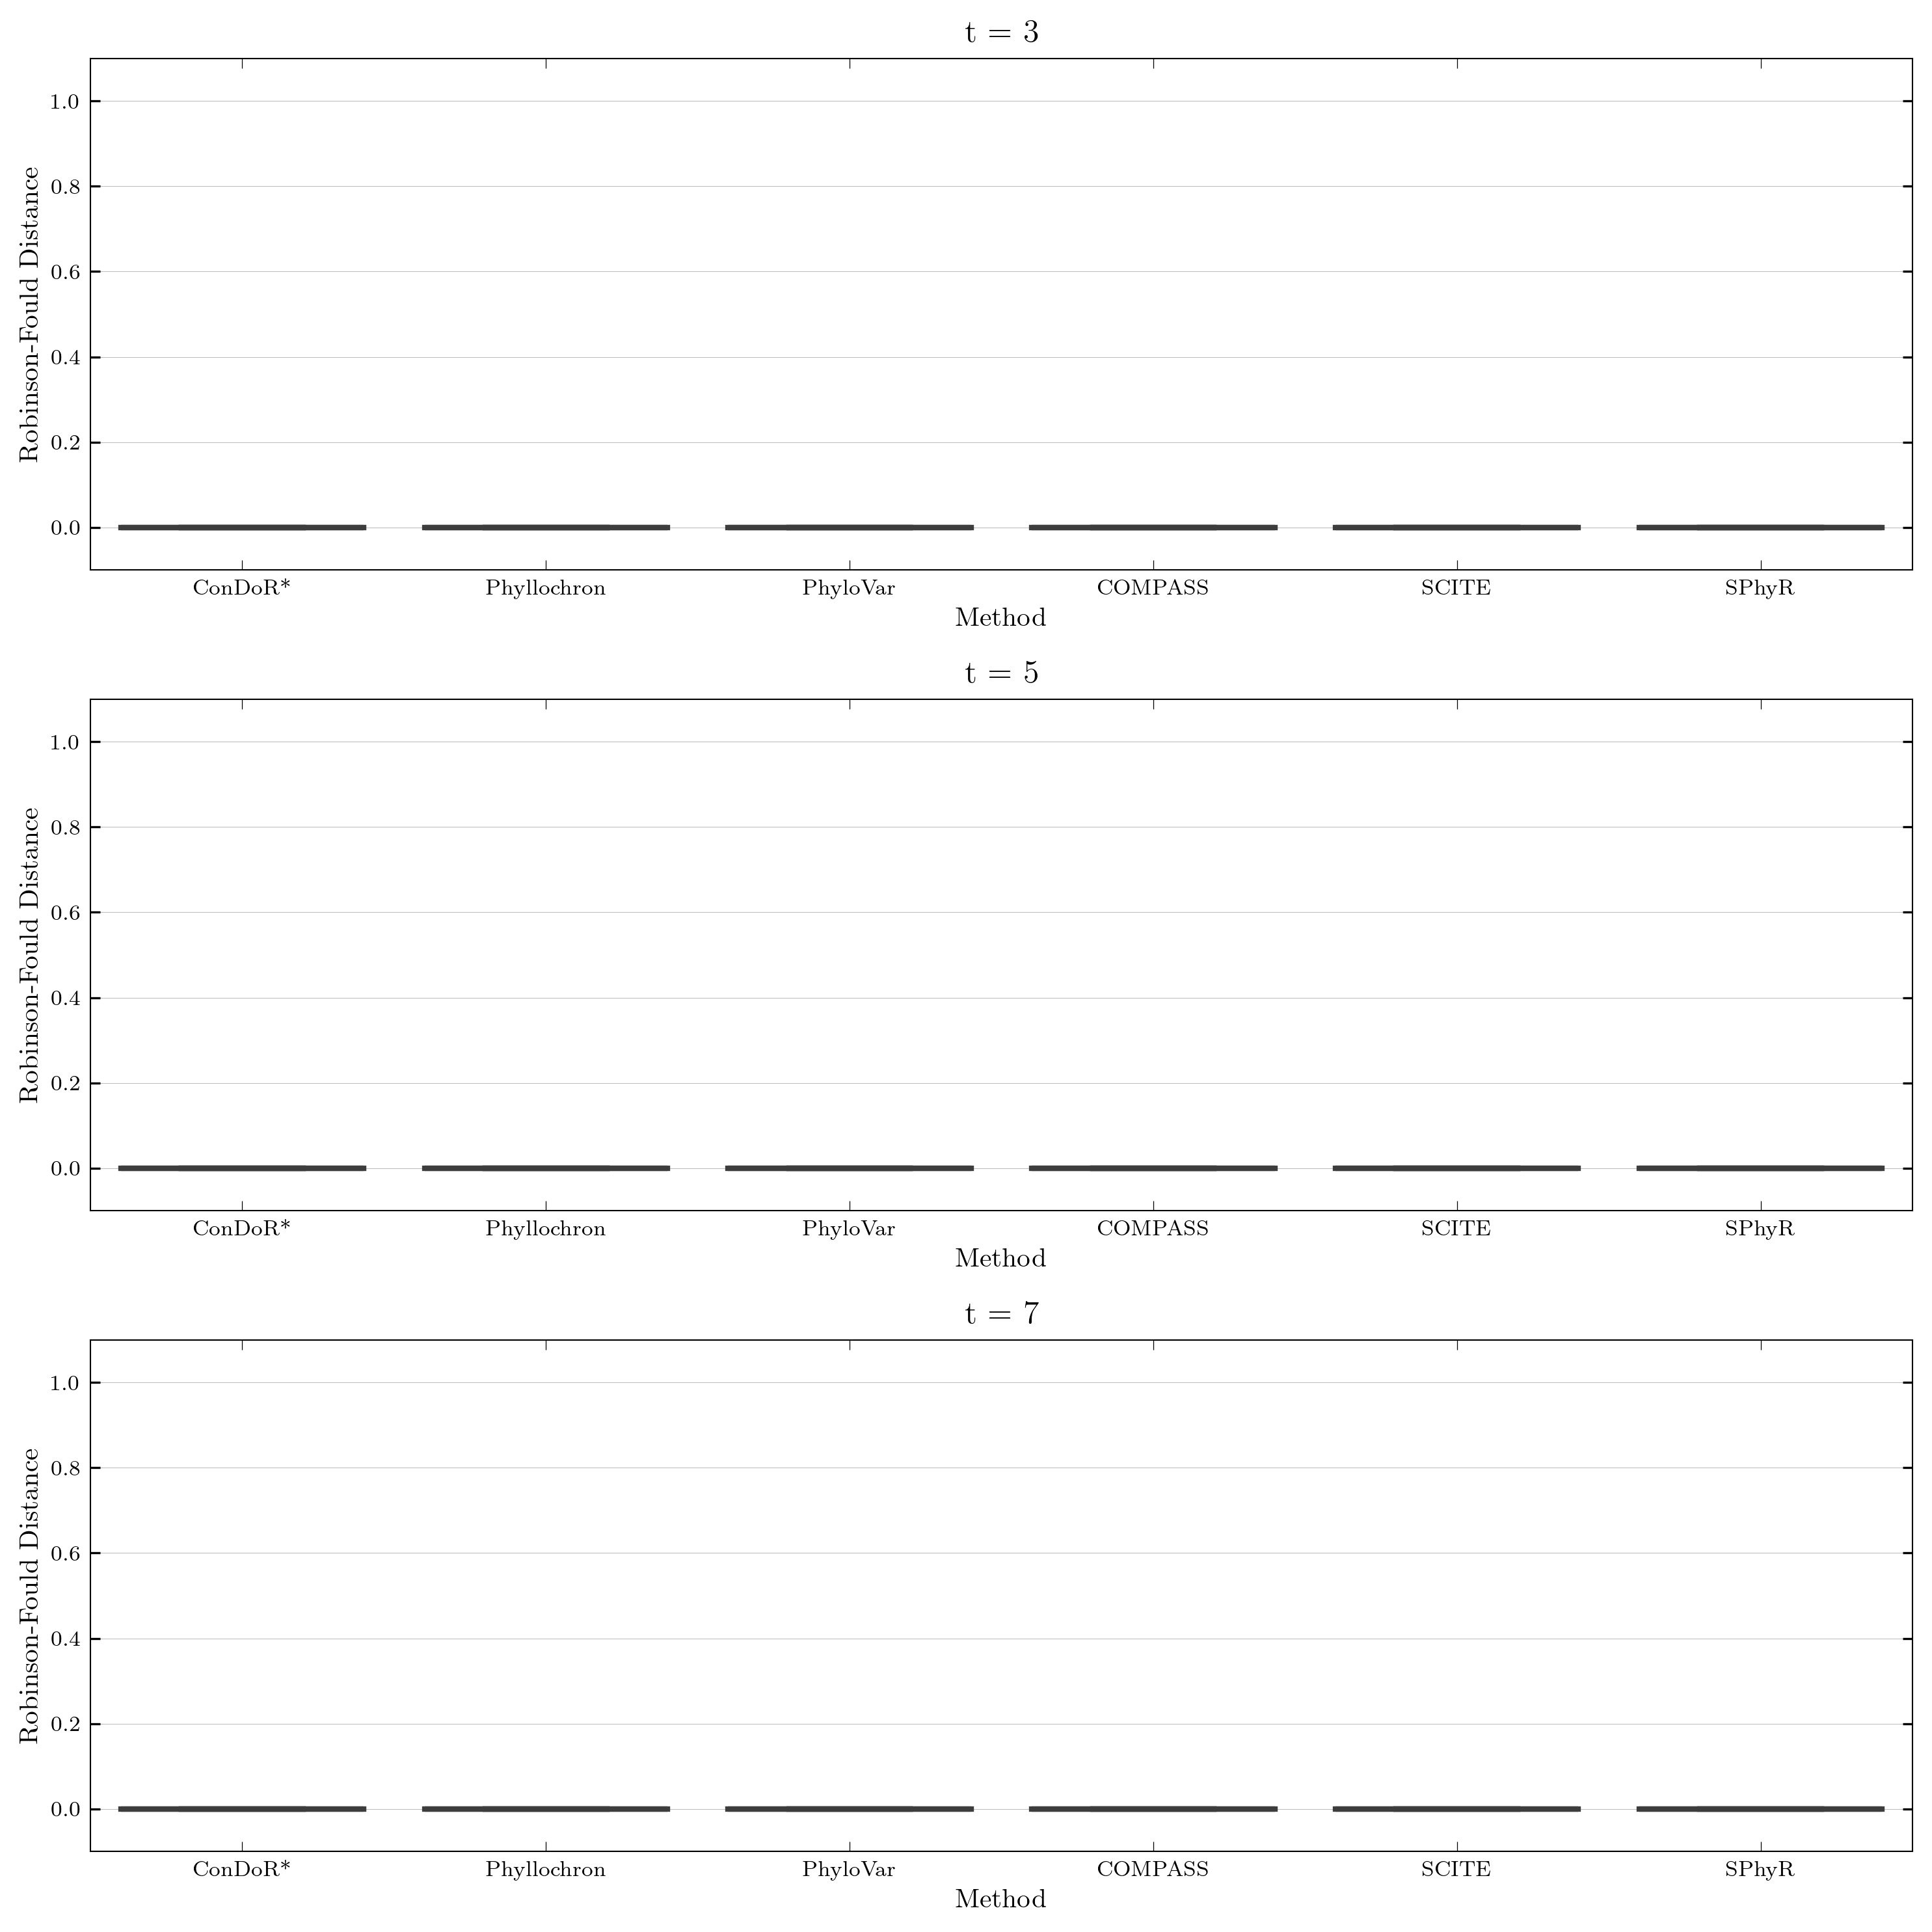

In [246]:
plt.figure()
fig, axs = plt.subplots(len(timepoints),1, figsize=(10,10))
for i, t in enumerate(timepoints):     
    phyllochron_pp_diffs = []
    phyllochron_diffs = []
    Phylovar_diffs = []
    COMPASS_diffs = []
    SCITE_diffs = []
    SPhyR_diffs = []
    for j, prop in enumerate(error_rates):
   

        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                
                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                SPhyR_character_matrix = sphyr_df.values

                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                Phylovar_character_matrix = Phylovar_df.values
                COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
                
                
                original_t = build_mutation_tree(np.unique(og_character_matrix, axis=0))
                phyllochron_t = build_mutation_tree(np.unique(phyllochron_character_matrix, axis=0))
                phyllochron_pp_t = build_mutation_tree(np.unique(phyllochron_pp_character_matrix, axis=0))
                Phylovar_t = build_mutation_tree(np.unique(Phylovar_character_matrix, axis=0))
                COMPASS_t = build_mutation_tree(np.unique(COMPASS_character_matrix, axis=0))
                SCITE_t = build_mutation_tree(np.unique(SCITE_character_matrix, axis=0))
                SPhyR_t = build_mutation_tree(np.unique(SPhyR_character_matrix, axis=0))

                phyllochron_pp_diffs.append(original_t.robinson_foulds(phyllochron_pp_t)[0])
                phyllochron_diffs.append(original_t.robinson_foulds(phyllochron_t)[0])
                Phylovar_diffs.append(original_t.robinson_foulds(Phylovar_t)[0])
                COMPASS_diffs.append(original_t.robinson_foulds(COMPASS_t)[0])
                SCITE_diffs.append(original_t.robinson_foulds(SCITE_t)[0])
                SPhyR_diffs.append(original_t.robinson_foulds(SPhyR_t)[0])

        

    data = pd.DataFrame({'Method': len(error_rates)*num_replicates*['ConDoR*'] + len(error_rates)*num_replicates*['Phyllochron'] + len(error_rates)*num_replicates*['PhyloVar'] + len(error_rates)*num_replicates*['COMPASS'] + len(error_rates)*num_replicates*['SCITE'] + len(error_rates)*num_replicates*['SPhyR'],'Robinson-Fould Distance':phyllochron_pp_diffs + phyllochron_diffs + Phylovar_diffs + COMPASS_diffs + SCITE_diffs + SPhyR_diffs})

    axs[i].set_ylim(-0.100, 1.1)

    sns.boxplot(x='Method', y='Robinson-Fould Distance', data=data, ax = axs[i])
    axs[i].set_title(f't = {t}')
fig.tight_layout()
plt.show()

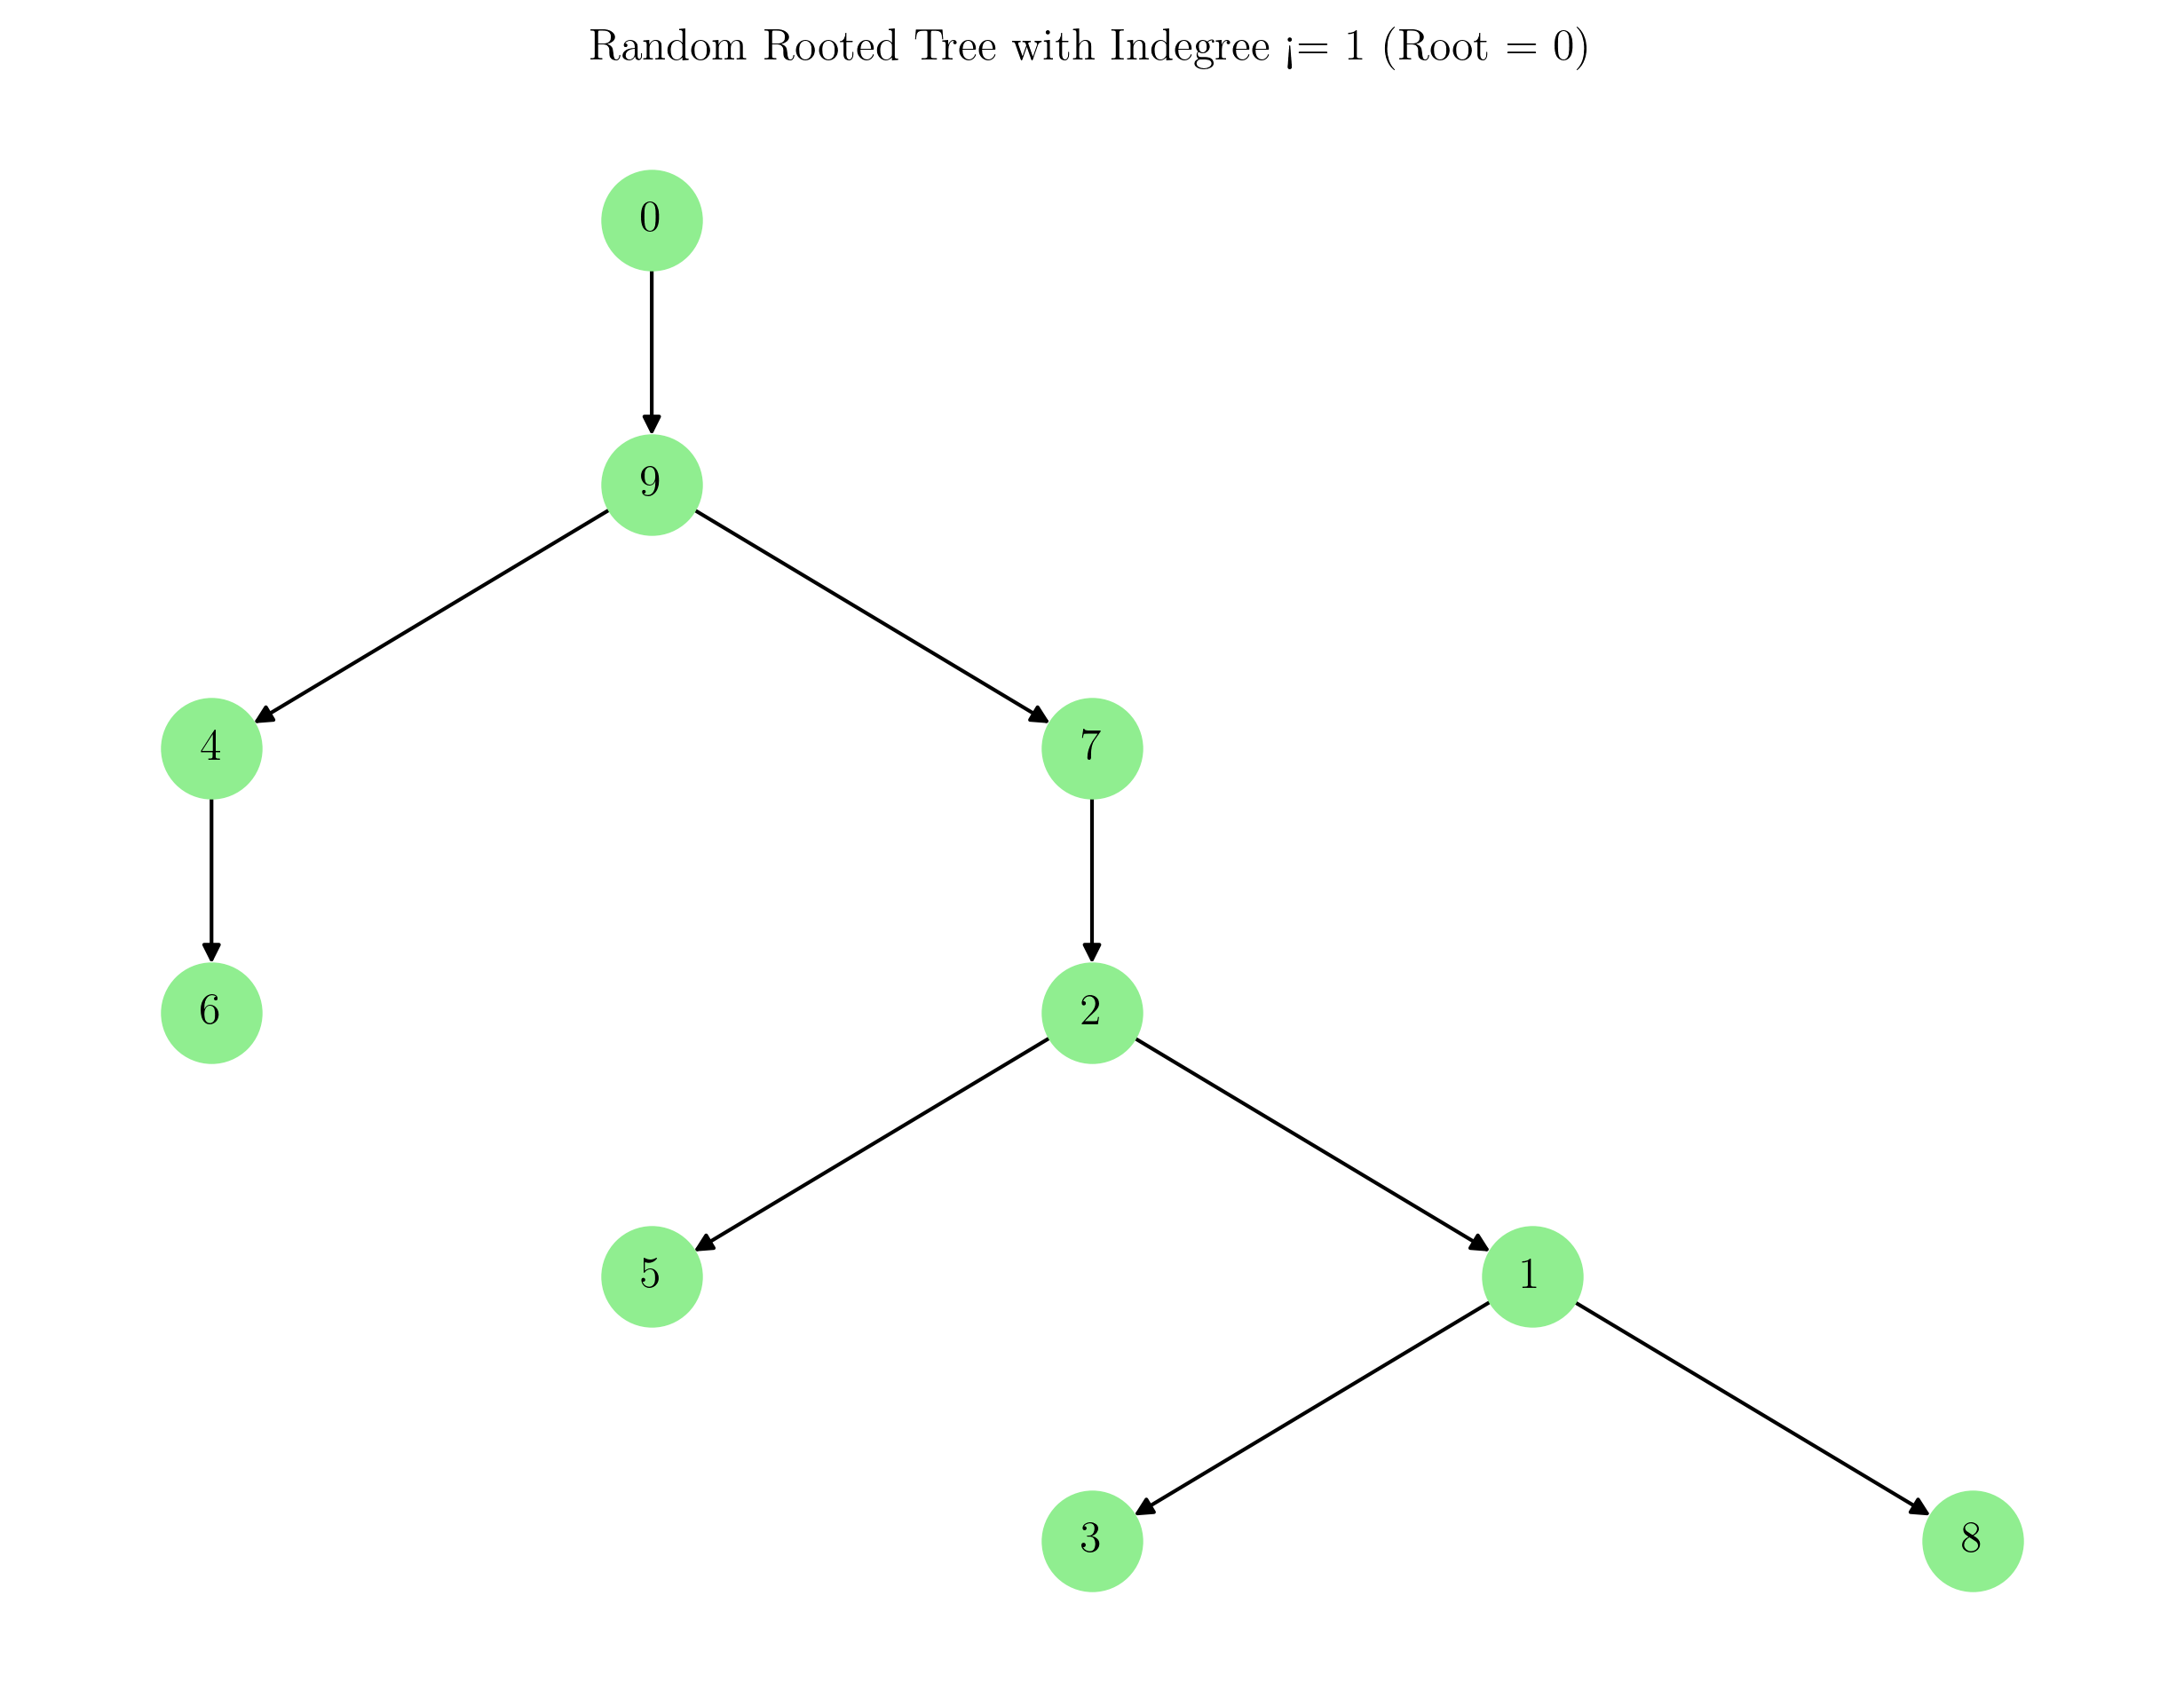

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]]


In [336]:
import networkx as nx
import matplotlib.pyplot as plt

n = 10  # Change to your desired number of nodes

# Generate a random tree
random_tree = nx.random_tree(n)

# Convert to a directed tree (with root at node 0)
root = 0
directed_tree = nx.bfs_tree(random_tree, root)

# Check indegree of all nodes to ensure it’s ≤ 1
for node in directed_tree.nodes:
    assert directed_tree.in_degree(node) <= 1, f"Node {node} has indegree > 1"

# Draw the directed tree
pos = nx.drawing.nx_agraph.graphviz_layout(directed_tree, prog="dot", root=root)

plt.figure(figsize=(8, 6))
nx.draw(directed_tree, pos, with_labels=True, arrows=True, node_color='lightgreen', node_size=700, font_size=12, font_weight='bold')
plt.title(f"Random Rooted Tree with Indegree <= 1 (Root = {root})")
plt.show()


def generate_perfect_phylogeny_matrix (graph):
    root = [node for node, indegree in graph.in_degree() if indegree == 0][0] 
    normal_profile = np.zeros(len(graph.nodes())) 
    profiles = [normal_profile]
    def rec_generation(curr_node, curr_profile, profiles):
        profiles.append(curr_profile)
        for child in list(graph.successors (curr_node)): 
            new_profile = curr_profile.copy() 
            new_profile[int(child)] = 1
            rec_generation (child, new_profile, profiles)

    f_profile = normal_profile.copy()
    f_profile[int(root)] = 1
    rec_generation (root, f_profile, profiles)
    matrix = np.array(profiles)
    return matrix
print(generate_perfect_phylogeny_matrix(directed_tree))

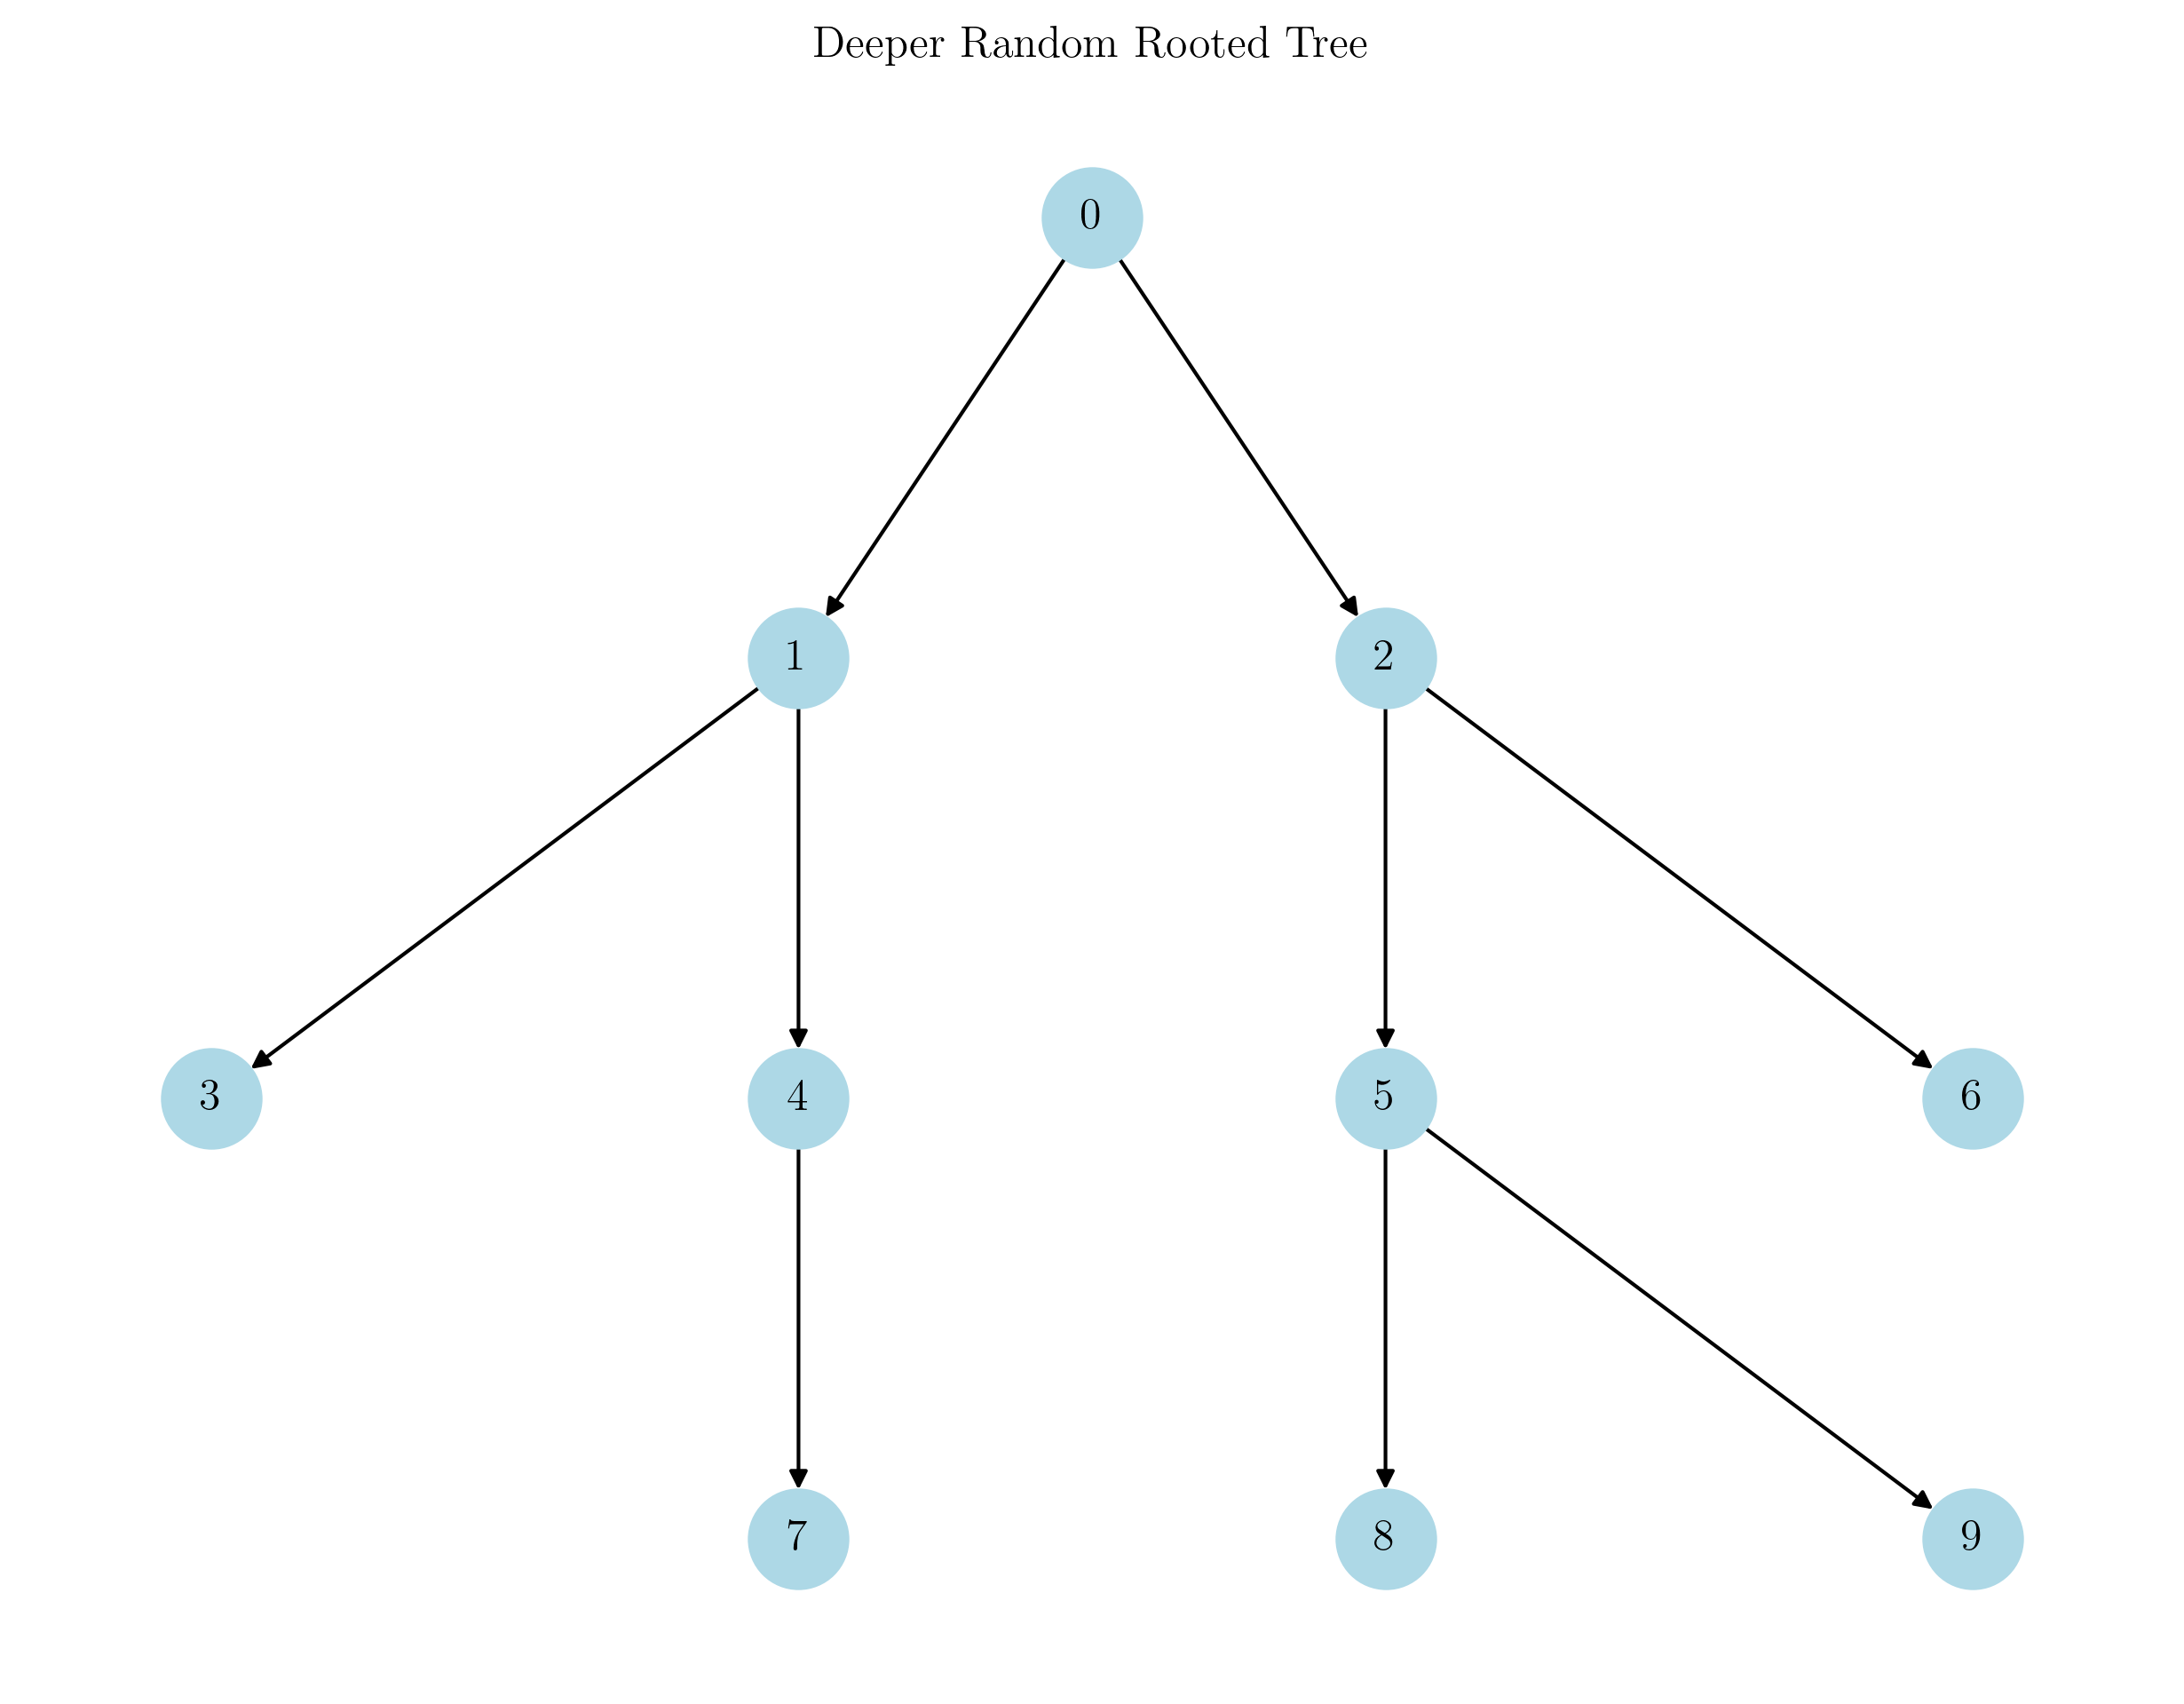

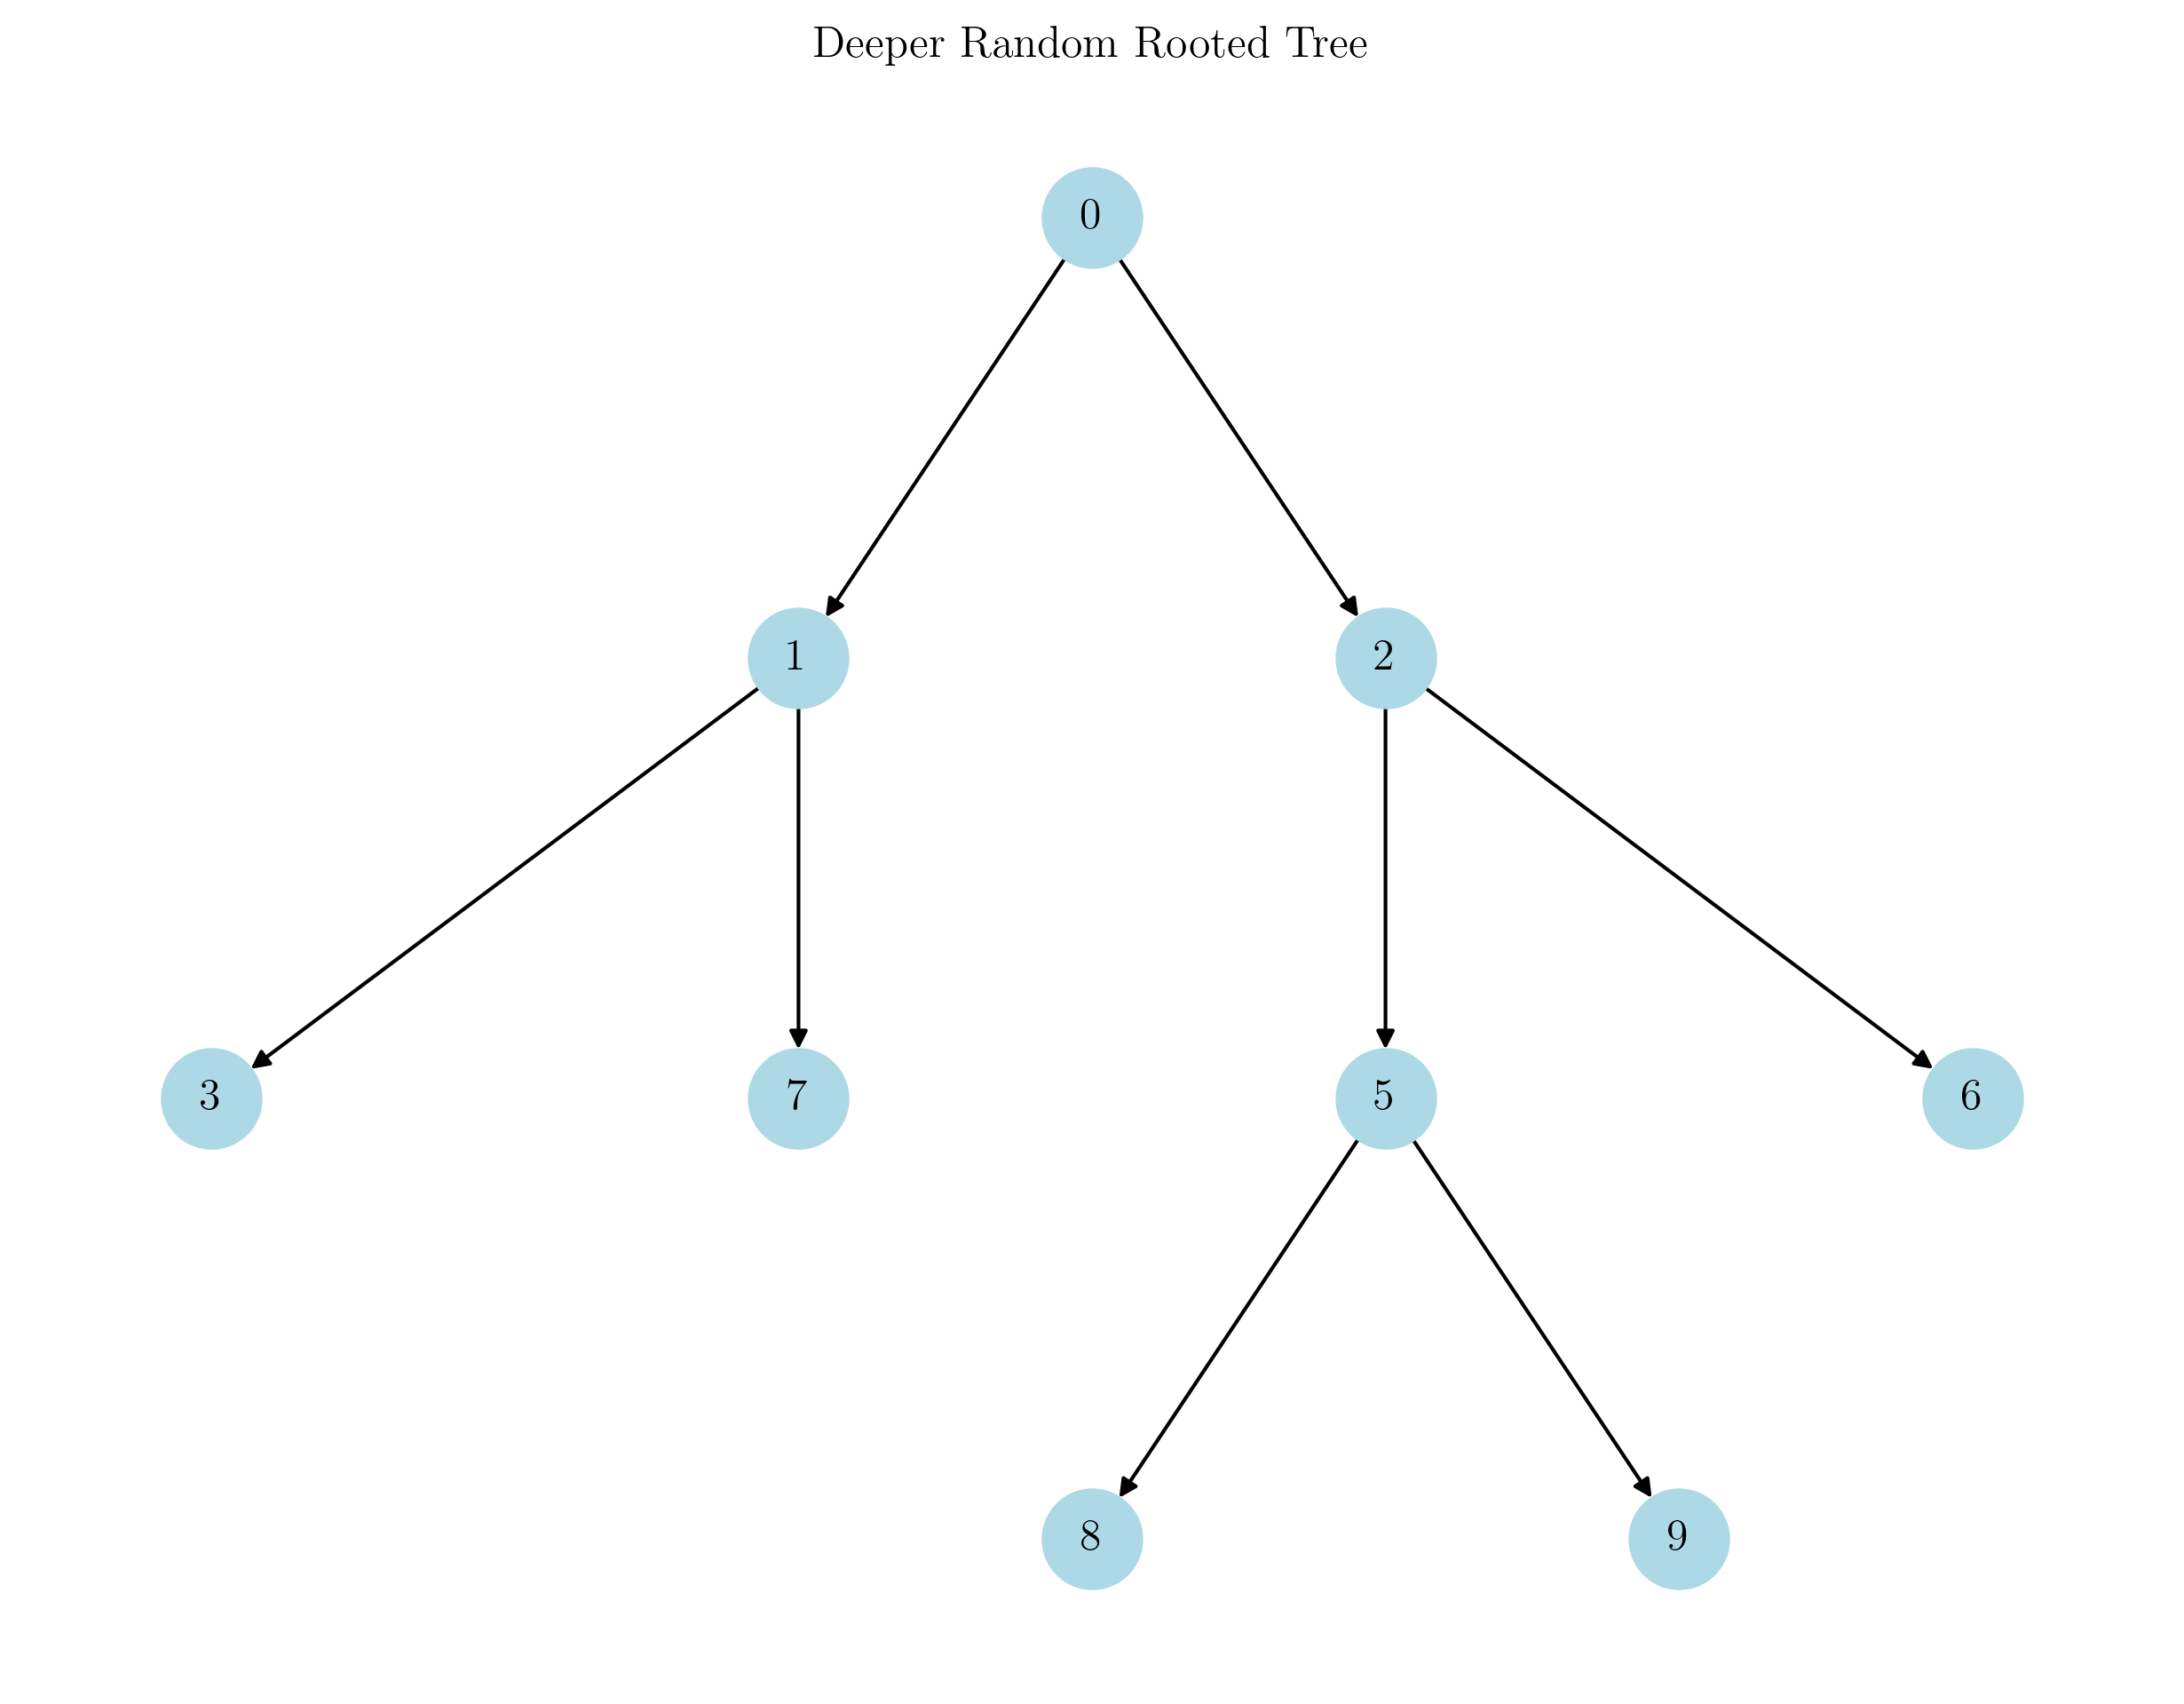

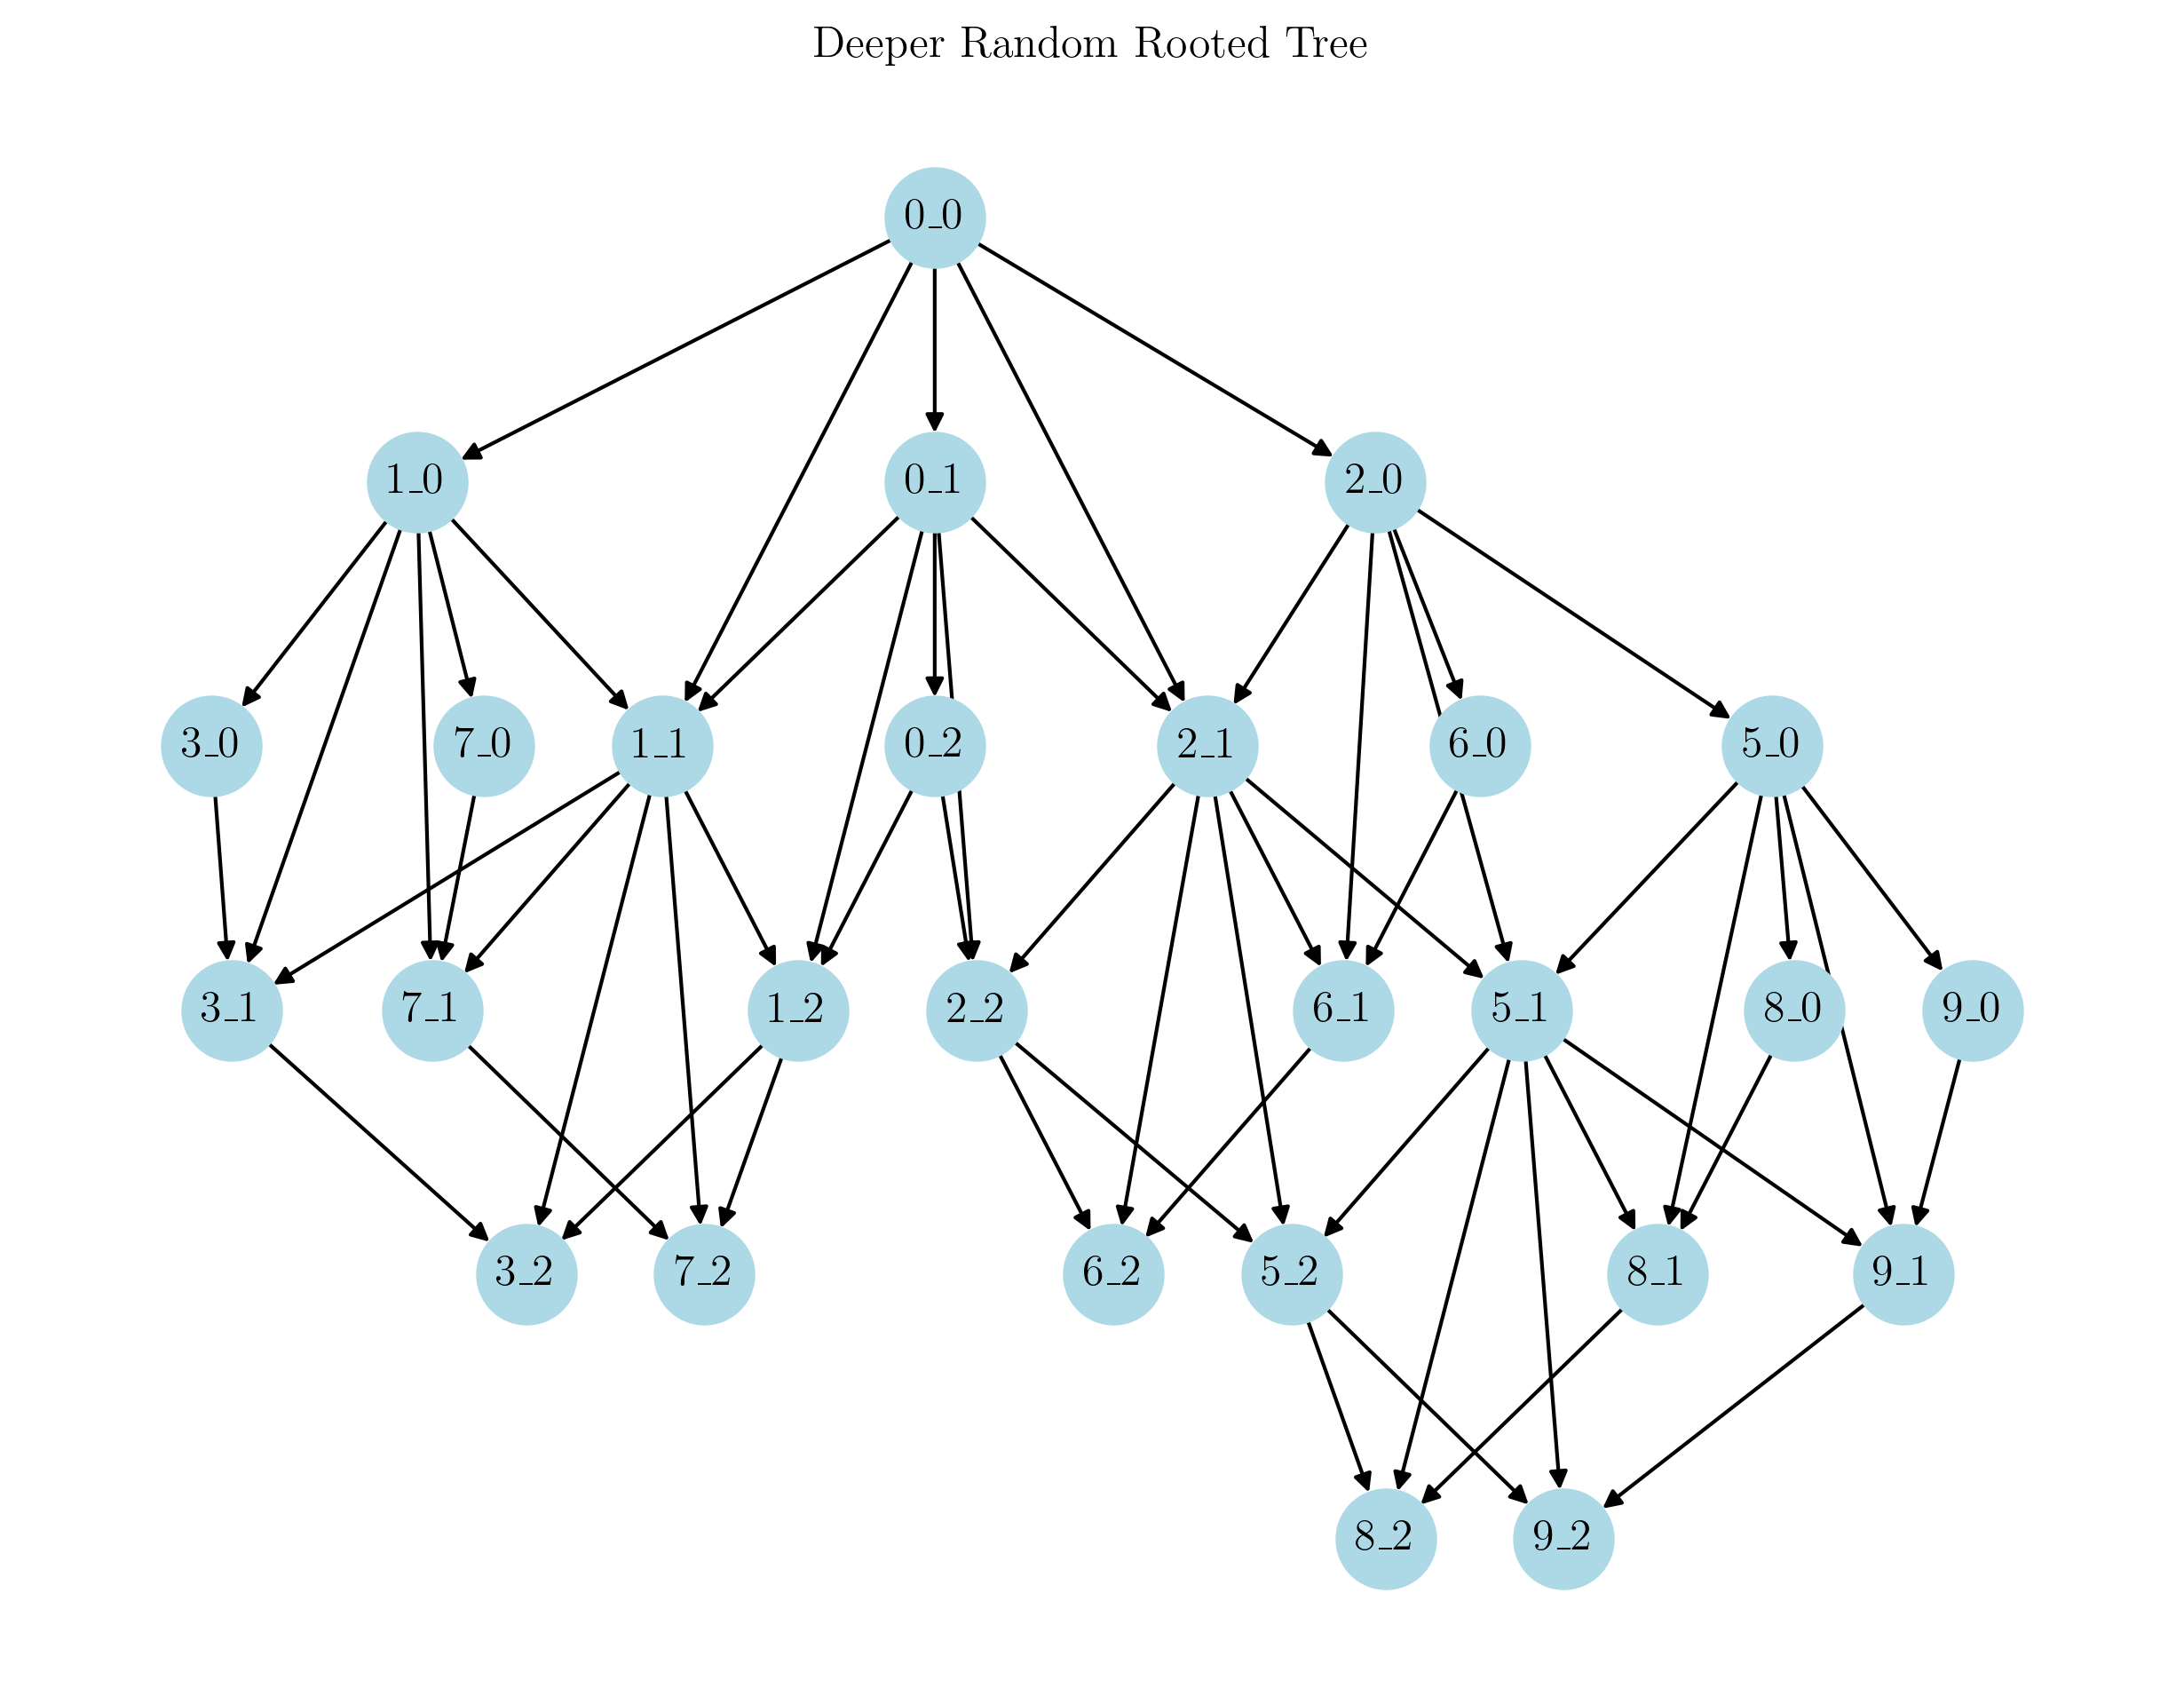

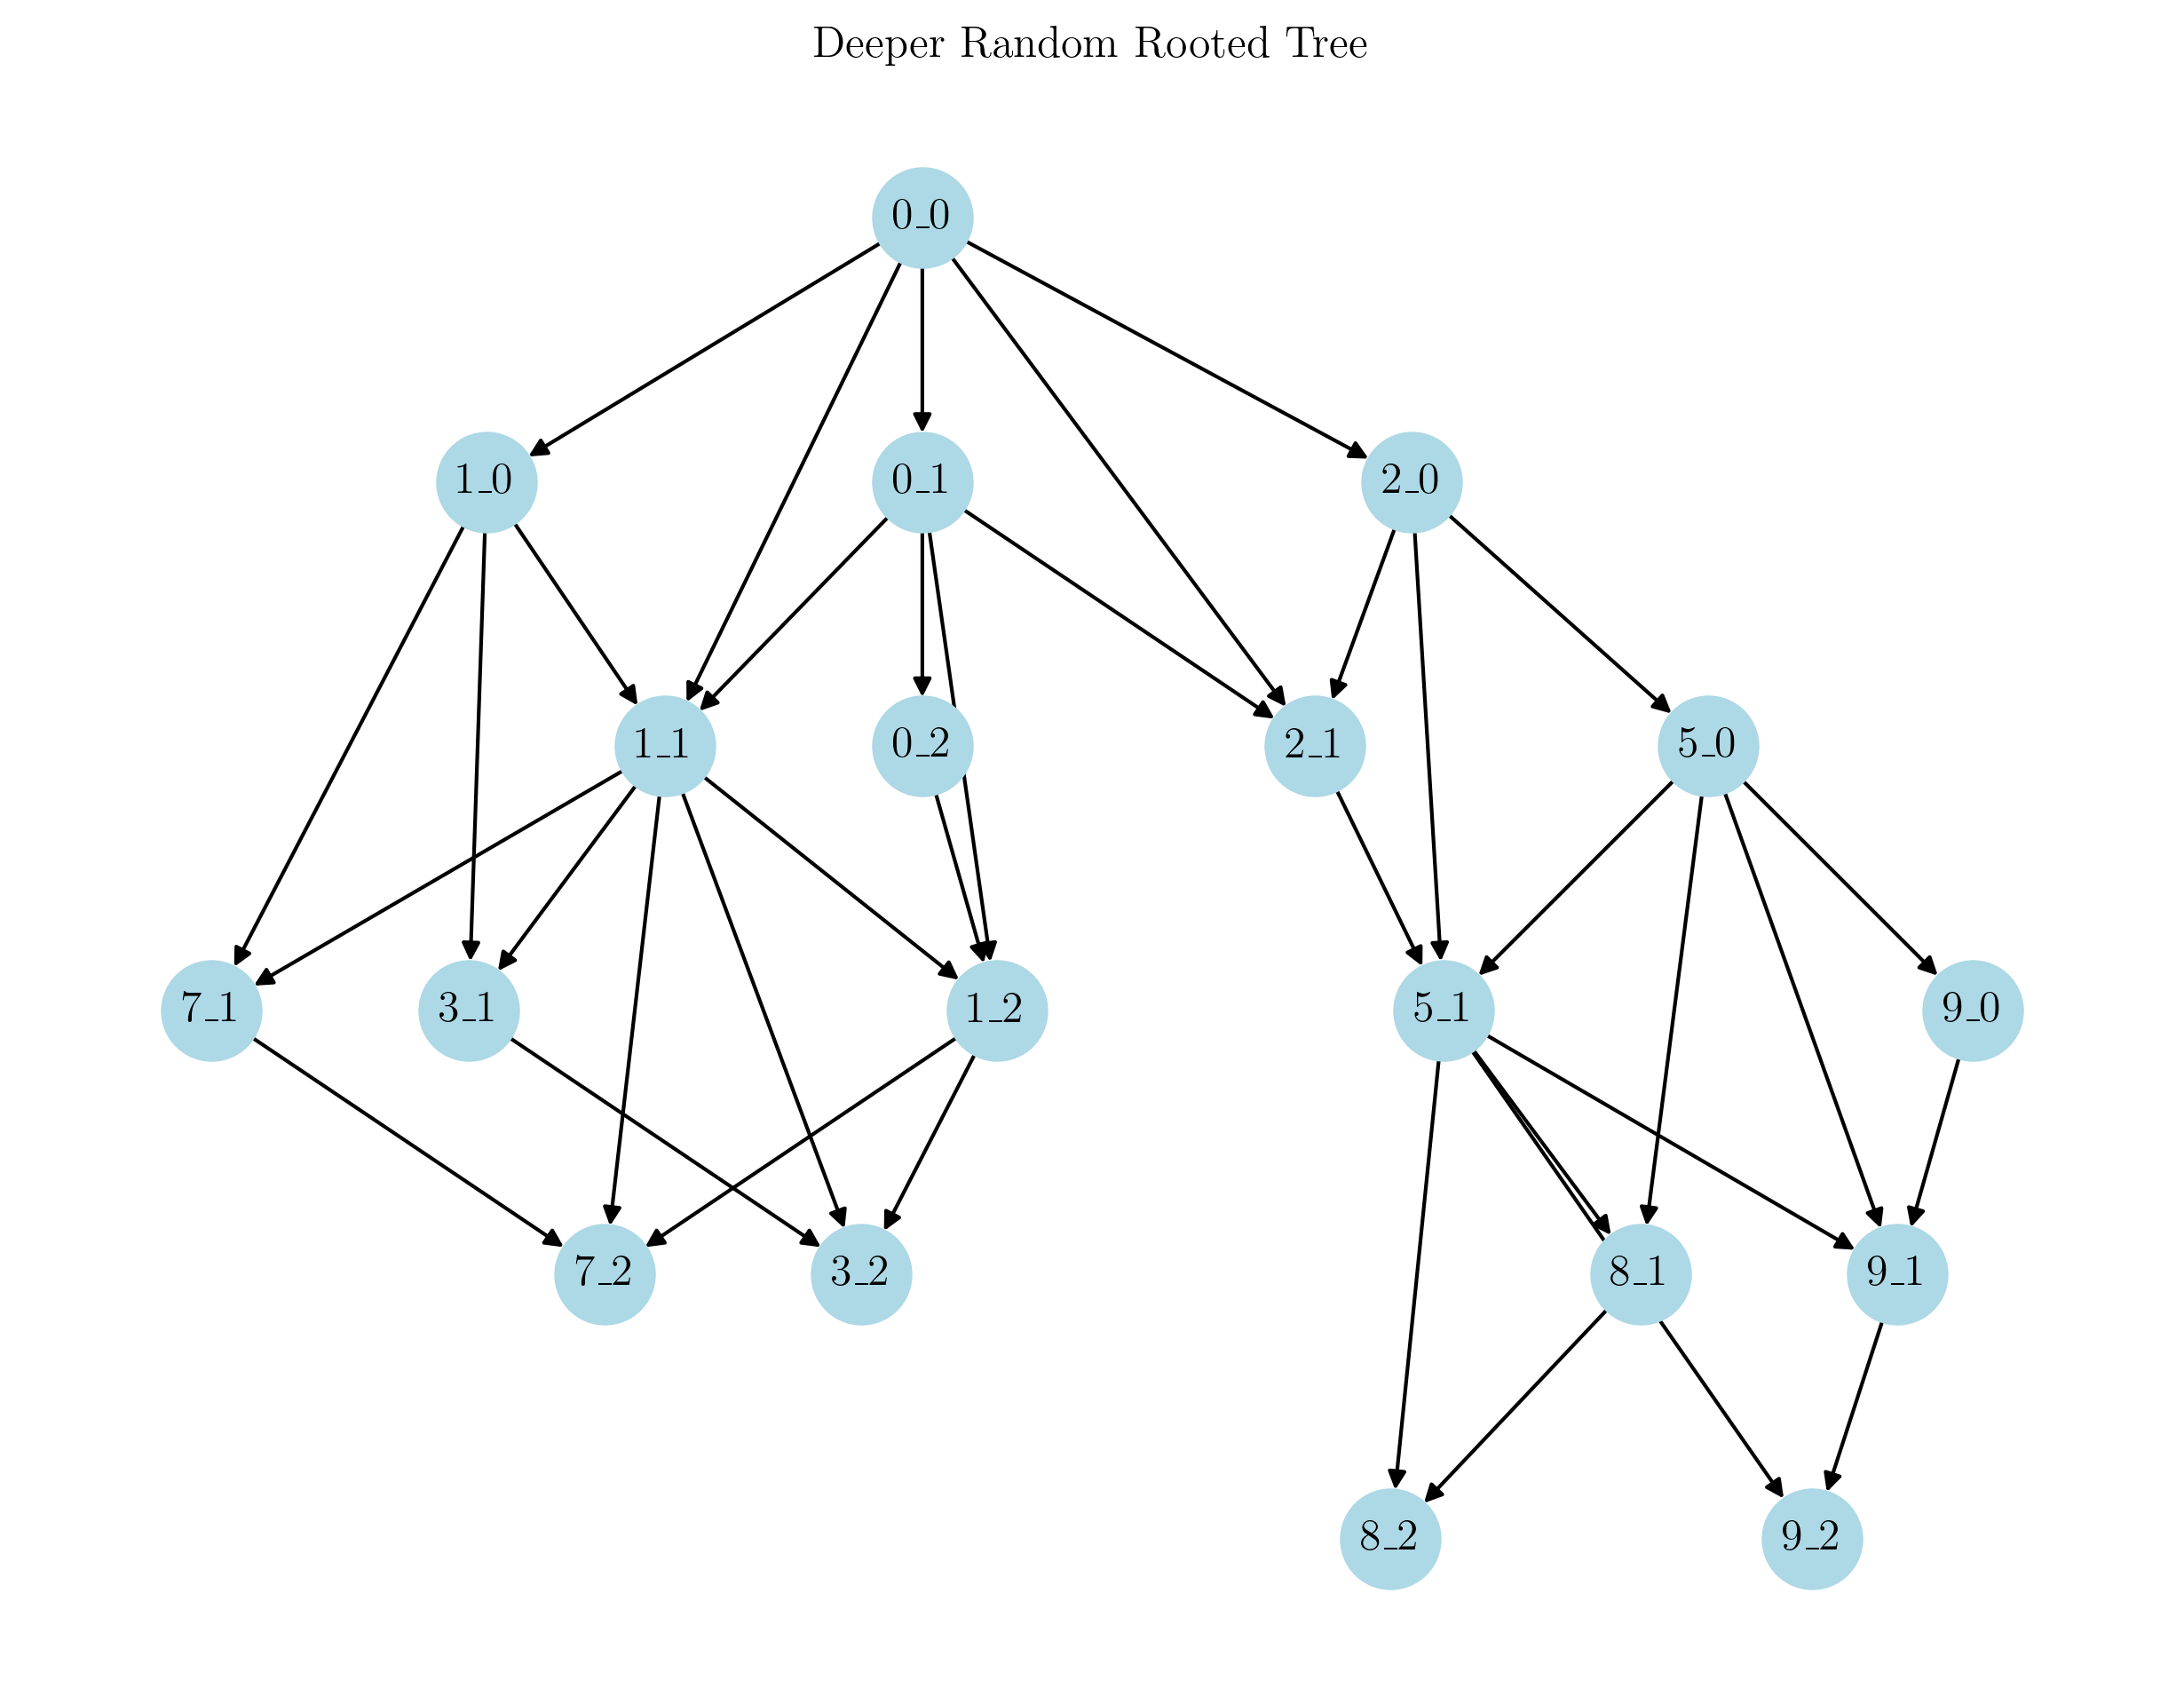

In [531]:
# Number of nodes in the tree
n = 10  # You can increase this to make the tree deeper

# Start with a root node
random_tree = nx.DiGraph()
random_tree.add_node(0)  # Add root node

# Grow the tree by preferentially attaching new nodes to existing nodes
for i in range(1, n):
    # Pick a random existing node with a bias towards nodes with low indegree (favoring depth)
    # Here, you could bias towards nodes with a smaller degree for deeper trees
    candidates = [node for node in random_tree.nodes if random_tree.out_degree(node) < 2]
    if candidates:
        parent = random.choice(candidates)
        random_tree.add_edge(parent, i)

# Check indegree of all nodes to ensure it’s ≤ 1 (should be guaranteed by the tree structure)
for node in random_tree.nodes:
    assert random_tree.in_degree(node) <= 1, f"Node {node} has indegree > 1"
    
def remove_nodes_keep_connected_digraph(tree, p):
    """
    Randomly remove nodes from a directed tree with probability p while keeping it connected.
    """
    G = tree.copy()
    for node in list(G.nodes):
        # Skip root and leaf nodes to avoid breaking connectivity
        if G.in_degree(node) == 1 and G.out_degree(node) > 0 and np.random.random() < p:
            parent = next(G.predecessors(node))
            children = list(G.successors(node))
            
            # Connect each child to the node's parent
            for child in children:
                G.add_edge(parent, child)
                
            # Remove the node
            G.remove_node(node)
    
    return G

pos = nx.drawing.nx_agraph.graphviz_layout(random_tree, prog="dot", root=0)

plt.figure(figsize=(8, 6))
nx.draw(random_tree, pos, with_labels=True, arrows=True, node_color='lightblue', node_size=700, font_size=12, font_weight='bold')
plt.title("Deeper Random Rooted Tree")
plt.show()


random_tree = remove_nodes_keep_connected_digraph(random_tree, 0.5)

pos = nx.drawing.nx_agraph.graphviz_layout(random_tree, prog="dot", root=0)

plt.figure(figsize=(8, 6))
nx.draw(random_tree, pos, with_labels=True, arrows=True, node_color='lightblue', node_size=700, font_size=12, font_weight='bold')
plt.title("Deeper Random Rooted Tree")
plt.show()
    
    
ntimepoints = 3

random_lifespan_tree = nx.DiGraph()
for n in random_tree.nodes():
    for t in range(ntimepoints):
        random_lifespan_tree.add_node(f"{n}_{t}")
    for t in range(1,ntimepoints):
        random_lifespan_tree.add_edge(f"{n}_{t-1}", f"{n}_{t}")

for (u,v) in random_tree.edges():
    for t in range(ntimepoints):
        random_lifespan_tree.add_edge(f"{u}_{t}", f"{v}_{t}")
    for t in range(ntimepoints - 1):
        random_lifespan_tree.add_edge(f"{u}_{t}", f"{v}_{t+1}")

# Randomly delete edges w/ probability p s.t. resulting graph is LC
def delete_nodes_with_connectivity(G, p):
    # Make a copy of the graph to avoid modifying the original
    G_copy = G.copy()
    
    # Keep trying until we get a single connected component after node deletions
    while True:
        # Generate a list of nodes to delete with probability p
        nodes_to_delete = [node for node in G_copy.nodes if random.random() < p]
        
        # Remove the selected nodes
        G_temp = G_copy.copy()
        G_temp.remove_nodes_from(nodes_to_delete)
        
        isValid = True
        
        for n in range(nmutations):
            for t1 in range(ntimepoints - 2):
                for t2 in range(t1 + 1, ntimepoints - 1):
                    for t3 in range(t2 + 1, ntimepoints):
                        if f"{n}_{t1}" in G_temp.nodes() and f"{n}_{t2}" not in G_temp.nodes() and f"{n}_{t3}" in G_temp.nodes():
                            isValid = False
                            
        def is_reachable_from_single_root(G):
            # Find nodes with in-degree 0
            roots = [node for node in G.nodes if G.in_degree(node) == 0]

            # There must be exactly one node with in-degree 0
            if len(roots) != 1:
                return False

            # Get the single root node
            root = roots[0]

            # Check if all nodes are reachable from the root node
            reachable_nodes = nx.descendants(G, root)  # All nodes reachable from root
            reachable_nodes.add(root)  # Include the root itself

            return len(reachable_nodes) == len(G)
        
        # Check if the resulting graph is strongly connected
        if nx.is_connected(nx.Graph(G_temp)) and isValid and len(nodes_to_delete) > 0 and is_reachable_from_single_root(G_temp):
            return G_temp  # Return the modified graph if it's still strongly connected
        

pos = nx.drawing.nx_agraph.graphviz_layout(random_lifespan_tree, prog="dot", root=0)

plt.figure(figsize=(8, 6))
nx.draw(random_lifespan_tree, pos, with_labels=True, arrows=True, node_color='lightblue', node_size=700, font_size=12, font_weight='bold')
plt.title("Deeper Random Rooted Tree")
plt.show()

random_lifespan_tree = delete_nodes_with_connectivity(random_lifespan_tree, p=0.5)
# Draw the directed tree
pos = nx.drawing.nx_agraph.graphviz_layout(random_lifespan_tree, prog="dot", root=0)

plt.figure(figsize=(8, 6))
nx.draw(random_lifespan_tree, pos, with_labels=True, arrows=True, node_color='lightblue', node_size=700, font_size=12, font_weight='bold')
plt.title("Deeper Random Rooted Tree")
plt.show()